# Model Experimentation Tracking (MLFow) - Hyperparamter Optimization

Record and query experiments: Code, data, config, results, parameters, metrics

![Data](images/MLflow_Model_experimentation.png)

## Import Packages

In [29]:
# Data analysis library
import numpy as np
import pandas as pd
import joblib

# Machine Learning library
import sklearn
from sklearn.metrics import roc_curve, auc, accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_metric

# Model experimentation library
import mlflow
import mlflow.lightgbm
from mlflow.tracking import MlflowClient

# Hyperparameter tunning library
import optuna

# Plotting library
import matplotlib.pyplot as plt
# Prevent figures from displaying by turning interactive mode off using the function
plt.ioff()
import warnings
warnings.filterwarnings("ignore")

INFO:matplotlib.font_manager:generated new fontManager


In [30]:
print(f'Numpy version is {np.__version__}')
print(f'Pandas version is {pd.__version__}')
print(f'sklearn version is {sklearn.__version__}')
print(f'mlflow version is {mlflow.__version__}')
print(f'joblib version is {joblib.__version__}')
print(f'optuna version is {optuna.__version__}')

Numpy version is 1.22.4
Pandas version is 1.5.3
sklearn version is 1.1.2
mlflow version is 2.3.2
joblib version is 1.3.1
optuna version is 3.4.0


## Load data

In [31]:
## Files
data_file='/mnt/data/Heart-Attack-prediction/heart.csv'

# Load train loan dataset 
try:
    data = pd.read_csv(data_file)
    print("The dataset has {} samples with {} features.".format(*data.shape))
except:
    print("The dataset could not be loaded. Is the dataset missing?")
    


The dataset has 303 samples with 14 features.


## Introduction To The Data

In [32]:
data.head()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

In [33]:
data['output'].value_counts()

1    165
0    138
Name: output, dtype: int64

## Initialize MLflow

**Experiments** : You can organize runs into experiments, which group together runs for a specific task. 

**Tracking URI**: MLflow runs can be recorded to local files, to a database, or remotely to a tracking server. By default, the MLflow Python API logs runs locally to files in an mlruns directory wherever you ran your program

#### MLflow Tracking Servers 
MLflow tracking server has two components for storage: a **backend store** and an **artifact store**

The **backend store** is where MLflow Tracking Server stores experiment and run metadata as well as params, metrics, and tags for runs. MLflow supports two types of backend stores: **file store and database-backed store**.

The **artifact store** is a location suitable for large data (such as an S3 bucket or shared NFS file system) and is where clients log their artifact output (for example, models).

    Amazon S3 and S3-compatible storage
    Azure Blob Storage
    Google Cloud Storage
    FTP server
    SFTP Server
    NFS
    HDFS

In [34]:
experiment_name = "heart_attack_predictions_v2"

# Initialize client
client = MlflowClient()

# If experiment doesn't exist then it will create new
# else it will take the experiment id and will use to to run the experiments
try:
    # Create experiment 
    experiment_id = client.create_experiment(experiment_name)
except:
    # Get the experiment id if it already exists
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

## Prepare data for model training

In [35]:
exclude_feature = []
# Define Target columns
target = data['output']

# Define numeric and categorical features
numeric_features = [ 'age', 'trtbps', 'chol', 'thalachh', 'oldpeak' ]
categorical_features = [ 'sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall' ]


# Define final feature list for training and validation
features = numeric_features + categorical_features
# Final data for training and validation
data = data[features]
data = data.fillna(0)

# Split data in train and vlaidation
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.15, random_state=10)

# Perform label encoding for categorical variable
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(X_train.loc[:, feature])
    X_train.loc[:, feature] = le.transform(X_train.loc[:, feature])
    X_valid.loc[:, feature] = le.transform(X_valid.loc[:, feature])

## Lightgbm Hyperparameter tunning + MLFlow for model tracking

### Define model training function to train and track model results

In [36]:
def model_training_tracking(params):
    # Launching Multiple Runs in One Program.This is easy to do because the ActiveRun object returned by mlflow.start_run() is a 
    # Python context manager. You can “scope” each run to just one block of code as follows:
    with mlflow.start_run(experiment_id=experiment_id, run_name='Lightgbm_model') as run:
        # Get run id 
        run_id = run.info.run_uuid
        
        # Set the notes for the run
        MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "This is experiment for hyperparameter optimzation for lightgbm models for the Campus Recruitment Dataset")
        
        # Define customer tag
        tags = {"Application": "Payment Monitoring Platform",
                "release.candidate": "PMP",
                "release.version": "2.2.0"}

        # Set Tag
        mlflow.set_tags(tags)
                        
        # Log python environment details
        mlflow.log_artifact('requirements.txt')
        
        # logging params
        mlflow.log_params(params)

        # Perform model training
        lgb_clf = LGBMClassifier(**params)
        lgb_clf.fit(X_train, y_train, 
                    eval_set = [(X_train, y_train), (X_valid, y_valid)], 
                    early_stopping_rounds=50,
                    verbose=20)

        # Log model artifacts
        mlflow.sklearn.log_model(lgb_clf, "model")

        # Perform model evaluation 
        lgb_valid_prediction = lgb_clf.predict_proba(X_valid)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_valid, lgb_valid_prediction)
        roc_auc = auc(fpr, tpr) # compute area under the curve
        print("=====================================")
        print("Validation AUC:{}".format(roc_auc))
        print("=====================================")   

        # log metrics
        mlflow.log_metrics({"Validation_AUC": roc_auc})

        # Plot and save feature importance details
        ax = plot_importance(lgb_clf, height=0.4)
        filename = './images/lgb_validation_feature_importance.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename)

        ax = plot_metric(lgb_clf.evals_result_)
        filename = './images/lgb_validation_metrics_comparision.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename)

        # Plot and save metrics details    
        plot_confusion_matrix(lgb_clf, X_valid, y_valid, 
                              display_labels=['Placed', 'Not Placed'],
                              cmap='magma')
        plt.title('Confusion Matrix')
        filename = './images/lgb_validation_confusion_matrix.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename)

        # Plot and save AUC details  
        plot_roc_curve(lgb_clf, X_valid, y_valid, name='Validation')
        plt.title('ROC AUC Curve')
        filename = './images/lgb_validation_roc_curve.png'
        plt.savefig(filename)
        # log model artifacts
        mlflow.log_artifact(filename)
        
        return roc_auc

### Define an objective function to be maximized

In [37]:
def objective(trial):

    param = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "random_state": 42,
    }
    
    auc = model_training_tracking(param)
    return auc

### Create a study object and optimize the objective function

[I 2023-10-17 21:54:20,893] A new study created in memory with name: no-name-c07f4485-2d53-4494-ae57-c47e7c045ac8


[20]	training's auc: 0.958472	valid_1's auc: 0.925926
[40]	training's auc: 0.969271	valid_1's auc: 0.923977
[60]	training's auc: 0.980193	valid_1's auc: 0.927875
Validation AUC:0.9366471734892787


[I 2023-10-17 21:54:29,055] Trial 0 finished with value: 0.9366471734892787 and parameters: {'learning_rate': 0.03813685833380042, 'colsample_bytree': 0.5408795671085447, 'subsample': 0.4086298368819799}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.952518	valid_1's auc: 0.908382
[40]	training's auc: 0.96526	valid_1's auc: 0.916179
[60]	training's auc: 0.971091	valid_1's auc: 0.922027
[80]	training's auc: 0.978712	valid_1's auc: 0.920078
[100]	training's auc: 0.984574	valid_1's auc: 0.922027
Validation AUC:0.9220272904483431


[I 2023-10-17 21:54:36,451] Trial 1 finished with value: 0.9220272904483431 and parameters: {'learning_rate': 0.02780468915767902, 'colsample_bytree': 0.827535643869728, 'subsample': 0.8483661169034931}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.95659	valid_1's auc: 0.927875
[40]	training's auc: 0.966	valid_1's auc: 0.925926
[60]	training's auc: 0.972356	valid_1's auc: 0.920078
Validation AUC:0.9337231968810916


[I 2023-10-17 21:54:43,730] Trial 2 finished with value: 0.9337231968810916 and parameters: {'learning_rate': 0.02661861908549432, 'colsample_bytree': 0.656881153482398, 'subsample': 0.43916412038056607}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.952209	valid_1's auc: 0.906433
[40]	training's auc: 0.962452	valid_1's auc: 0.912281
[60]	training's auc: 0.966247	valid_1's auc: 0.916179
Validation AUC:0.9239766081871346


[I 2023-10-17 21:54:50,839] Trial 3 finished with value: 0.9239766081871346 and parameters: {'learning_rate': 0.02114236508529044, 'colsample_bytree': 0.7450024388693566, 'subsample': 0.5097136653032565}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.953474	valid_1's auc: 0.927875
[40]	training's auc: 0.958472	valid_1's auc: 0.931774
[60]	training's auc: 0.963779	valid_1's auc: 0.927875
[80]	training's auc: 0.967049	valid_1's auc: 0.923977
Validation AUC:0.9337231968810915


[I 2023-10-17 21:54:57,993] Trial 4 finished with value: 0.9337231968810915 and parameters: {'learning_rate': 0.013027636468490719, 'colsample_bytree': 0.6792796962541281, 'subsample': 0.6535883859800828}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.937338	valid_1's auc: 0.903509
[40]	training's auc: 0.95224	valid_1's auc: 0.920078
[60]	training's auc: 0.960632	valid_1's auc: 0.920078
[80]	training's auc: 0.966741	valid_1's auc: 0.918129
Validation AUC:0.9239766081871345


[I 2023-10-17 21:55:05,440] Trial 5 finished with value: 0.9239766081871345 and parameters: {'learning_rate': 0.018064685931920184, 'colsample_bytree': 0.9624919544499158, 'subsample': 0.9363094410415878}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.970135	valid_1's auc: 0.920078
[40]	training's auc: 0.988584	valid_1's auc: 0.922027
[60]	training's auc: 0.995249	valid_1's auc: 0.906433
Validation AUC:0.9337231968810916


[I 2023-10-17 21:55:12,610] Trial 6 finished with value: 0.9337231968810916 and parameters: {'learning_rate': 0.08185159317182387, 'colsample_bytree': 0.4637757694092319, 'subsample': 0.8786188093287176}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.954646	valid_1's auc: 0.925926
[40]	training's auc: 0.960015	valid_1's auc: 0.929825
[60]	training's auc: 0.965692	valid_1's auc: 0.925926
[80]	training's auc: 0.969888	valid_1's auc: 0.923977
Validation AUC:0.935672514619883


[I 2023-10-17 21:55:19,927] Trial 7 finished with value: 0.935672514619883 and parameters: {'learning_rate': 0.01701465070492038, 'colsample_bytree': 0.7052553362639948, 'subsample': 0.46776150024482754}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.947303	valid_1's auc: 0.901559
[40]	training's auc: 0.960786	valid_1's auc: 0.918129
[60]	training's auc: 0.972603	valid_1's auc: 0.916179
[80]	training's auc: 0.980316	valid_1's auc: 0.918129
[100]	training's auc: 0.986672	valid_1's auc: 0.922027
Validation AUC:0.9220272904483431


[I 2023-10-17 21:55:27,667] Trial 8 finished with value: 0.9220272904483431 and parameters: {'learning_rate': 0.02863301466342689, 'colsample_bytree': 0.9762615910847904, 'subsample': 0.8922559384001103}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.952209	valid_1's auc: 0.906433
[40]	training's auc: 0.962329	valid_1's auc: 0.912281
[60]	training's auc: 0.965198	valid_1's auc: 0.91423
Validation AUC:0.9239766081871346


[I 2023-10-17 21:55:34,950] Trial 9 finished with value: 0.9239766081871346 and parameters: {'learning_rate': 0.021384986081744967, 'colsample_bytree': 0.7723479932375429, 'subsample': 0.9199951435632152}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.957793	valid_1's auc: 0.918129
[40]	training's auc: 0.97322	valid_1's auc: 0.925926
[60]	training's auc: 0.982661	valid_1's auc: 0.929825
[80]	training's auc: 0.990065	valid_1's auc: 0.923977
Validation AUC:0.9337231968810917


[I 2023-10-17 21:55:42,191] Trial 10 finished with value: 0.9337231968810917 and parameters: {'learning_rate': 0.047950326617035625, 'colsample_bytree': 0.4565006244309052, 'subsample': 0.6163018083549876}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.951931	valid_1's auc: 0.923977
[40]	training's auc: 0.956744	valid_1's auc: 0.923977
[60]	training's auc: 0.962668	valid_1's auc: 0.927875
[80]	training's auc: 0.966247	valid_1's auc: 0.925926
Validation AUC:0.9298245614035088


[I 2023-10-17 21:55:49,959] Trial 11 finished with value: 0.9298245614035088 and parameters: {'learning_rate': 0.010443508042189766, 'colsample_bytree': 0.5911643032724512, 'subsample': 0.41124415320839863}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.960447	valid_1's auc: 0.923977
[40]	training's auc: 0.97396	valid_1's auc: 0.923977
[60]	training's auc: 0.985623	valid_1's auc: 0.929825
Validation AUC:0.9346978557504874


[I 2023-10-17 21:55:57,060] Trial 12 finished with value: 0.9346978557504874 and parameters: {'learning_rate': 0.048409086200725183, 'colsample_bytree': 0.574296949297092, 'subsample': 0.5287105110045014}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.961989	valid_1's auc: 0.916179
[40]	training's auc: 0.970566	valid_1's auc: 0.912281
[60]	training's auc: 0.980007	valid_1's auc: 0.918129
Validation AUC:0.9259259259259259


[I 2023-10-17 21:56:03,930] Trial 13 finished with value: 0.9259259259259259 and parameters: {'learning_rate': 0.040606099103624504, 'colsample_bytree': 0.4067161448337926, 'subsample': 0.5298984134558459}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.951129	valid_1's auc: 0.922027
[40]	training's auc: 0.95767	valid_1's auc: 0.920078
Validation AUC:0.9288499025341131


[I 2023-10-17 21:56:10,513] Trial 14 finished with value: 0.9288499025341131 and parameters: {'learning_rate': 0.015056770266735811, 'colsample_bytree': 0.5660620490168858, 'subsample': 0.4209464646914981}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.958781	valid_1's auc: 0.923977
[40]	training's auc: 0.970443	valid_1's auc: 0.918129
[60]	training's auc: 0.980501	valid_1's auc: 0.923977
Validation AUC:0.9346978557504874


[I 2023-10-17 21:56:17,587] Trial 15 finished with value: 0.9346978557504874 and parameters: {'learning_rate': 0.038679248278015894, 'colsample_bytree': 0.5480549967334015, 'subsample': 0.7128700663508035}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.953104	valid_1's auc: 0.927875
[40]	training's auc: 0.959706	valid_1's auc: 0.925926
[60]	training's auc: 0.966741	valid_1's auc: 0.923977
Validation AUC:0.935672514619883


[I 2023-10-17 21:56:25,117] Trial 16 finished with value: 0.935672514619883 and parameters: {'learning_rate': 0.01721946661397644, 'colsample_bytree': 0.6426986290156426, 'subsample': 0.48596733187149893}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.953135	valid_1's auc: 0.927875
[40]	training's auc: 0.957608	valid_1's auc: 0.935673
[60]	training's auc: 0.962051	valid_1's auc: 0.925926
[80]	training's auc: 0.964704	valid_1's auc: 0.923977
Validation AUC:0.935672514619883


[I 2023-10-17 21:56:32,493] Trial 17 finished with value: 0.935672514619883 and parameters: {'learning_rate': 0.010418624616799935, 'colsample_bytree': 0.7251024167969063, 'subsample': 0.40027606984498065}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.951561	valid_1's auc: 0.906433
[40]	training's auc: 0.962113	valid_1's auc: 0.912281
[60]	training's auc: 0.967018	valid_1's auc: 0.920078
[80]	training's auc: 0.973837	valid_1's auc: 0.923977
[100]	training's auc: 0.979946	valid_1's auc: 0.922027
Validation AUC:0.9220272904483431


[I 2023-10-17 21:56:39,662] Trial 18 finished with value: 0.9220272904483431 and parameters: {'learning_rate': 0.022327694718253913, 'colsample_bytree': 0.8165155278305638, 'subsample': 0.4752470711745837}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.95693	valid_1's auc: 0.927875
[40]	training's auc: 0.967173	valid_1's auc: 0.922027
[60]	training's auc: 0.976428	valid_1's auc: 0.920078
Validation AUC:0.9366471734892787


[I 2023-10-17 21:56:46,856] Trial 19 finished with value: 0.9366471734892787 and parameters: {'learning_rate': 0.03360326839927941, 'colsample_bytree': 0.5053338157794537, 'subsample': 0.5700087347299803}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.956991	valid_1's auc: 0.927875
[40]	training's auc: 0.967913	valid_1's auc: 0.923977
[60]	training's auc: 0.97686	valid_1's auc: 0.929825
Validation AUC:0.9366471734892787


[I 2023-10-17 21:56:54,804] Trial 20 finished with value: 0.9366471734892787 and parameters: {'learning_rate': 0.03519859391508885, 'colsample_bytree': 0.5011717299588873, 'subsample': 0.5775107984553026}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.956991	valid_1's auc: 0.927875
[40]	training's auc: 0.967173	valid_1's auc: 0.923977
[60]	training's auc: 0.976552	valid_1's auc: 0.925926
Validation AUC:0.9366471734892787


[I 2023-10-17 21:57:02,215] Trial 21 finished with value: 0.9366471734892787 and parameters: {'learning_rate': 0.03442855182690289, 'colsample_bytree': 0.5011291850730067, 'subsample': 0.5578263060268863}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.96094	valid_1's auc: 0.922027
[40]	training's auc: 0.973837	valid_1's auc: 0.925926
[60]	training's auc: 0.985684	valid_1's auc: 0.925926
Validation AUC:0.9346978557504874


[I 2023-10-17 21:57:09,677] Trial 22 finished with value: 0.9346978557504874 and parameters: {'learning_rate': 0.049048362259436394, 'colsample_bytree': 0.5193480665380692, 'subsample': 0.5883272920416163}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.954523	valid_1's auc: 0.916179
[40]	training's auc: 0.965568	valid_1's auc: 0.927875
[60]	training's auc: 0.97396	valid_1's auc: 0.931774
[80]	training's auc: 0.982476	valid_1's auc: 0.933723
[100]	training's auc: 0.986918	valid_1's auc: 0.931774
Validation AUC:0.9317738791423001


[I 2023-10-17 21:57:16,745] Trial 23 finished with value: 0.9317738791423001 and parameters: {'learning_rate': 0.03285941779716086, 'colsample_bytree': 0.4930958373804326, 'subsample': 0.5911440174156307}. Best is trial 0 with value: 0.9366471734892787.


[20]	training's auc: 0.963532	valid_1's auc: 0.920078
[40]	training's auc: 0.982044	valid_1's auc: 0.933723
[60]	training's auc: 0.991546	valid_1's auc: 0.931774
[80]	training's auc: 0.995866	valid_1's auc: 0.918129
Validation AUC:0.9376218323586745


[I 2023-10-17 21:57:24,122] Trial 24 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.06437719385435245, 'colsample_bytree': 0.4250719188640829, 'subsample': 0.6727781495898999}. Best is trial 24 with value: 0.9376218323586745.


[20]	training's auc: 0.967543	valid_1's auc: 0.912281
[40]	training's auc: 0.981427	valid_1's auc: 0.920078
[60]	training's auc: 0.989757	valid_1's auc: 0.920078
Validation AUC:0.9239766081871345


[I 2023-10-17 21:57:31,112] Trial 25 finished with value: 0.9239766081871345 and parameters: {'learning_rate': 0.0656977058822972, 'colsample_bytree': 0.41772598886383033, 'subsample': 0.7108873768840261}. Best is trial 24 with value: 0.9376218323586745.


[20]	training's auc: 0.973528	valid_1's auc: 0.929825
[40]	training's auc: 0.992595	valid_1's auc: 0.929825
[60]	training's auc: 0.997655	valid_1's auc: 0.920078
[80]	training's auc: 0.999568	valid_1's auc: 0.904483
Validation AUC:0.939571150097466


[I 2023-10-17 21:57:38,583] Trial 26 finished with value: 0.939571150097466 and parameters: {'learning_rate': 0.09535597002725109, 'colsample_bytree': 0.4412799415729244, 'subsample': 0.6588646317472676}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.972418	valid_1's auc: 0.922027
[40]	training's auc: 0.992287	valid_1's auc: 0.929825
[60]	training's auc: 0.997532	valid_1's auc: 0.922027
Validation AUC:0.9376218323586745


[I 2023-10-17 21:57:45,947] Trial 27 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.09631978659255054, 'colsample_bytree': 0.43929425667455946, 'subsample': 0.7890153868296338}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.972726	valid_1's auc: 0.906433
[40]	training's auc: 0.989325	valid_1's auc: 0.906433
[60]	training's auc: 0.997717	valid_1's auc: 0.910331
Validation AUC:0.9220272904483431


[I 2023-10-17 21:57:52,995] Trial 28 finished with value: 0.9220272904483431 and parameters: {'learning_rate': 0.09718111303045329, 'colsample_bytree': 0.4003227647400859, 'subsample': 0.7629562230791299}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.972479	valid_1's auc: 0.922027
[40]	training's auc: 0.99204	valid_1's auc: 0.927875
[60]	training's auc: 0.998149	valid_1's auc: 0.920078
Validation AUC:0.9376218323586745


[I 2023-10-17 21:57:59,814] Trial 29 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.09676345271531307, 'colsample_bytree': 0.44107338856653283, 'subsample': 0.7982371935000594}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.969394	valid_1's auc: 0.920078
[40]	training's auc: 0.987967	valid_1's auc: 0.933723
[60]	training's auc: 0.994015	valid_1's auc: 0.923977
Validation AUC:0.9376218323586745


[I 2023-10-17 21:58:07,148] Trial 30 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.07859645964141602, 'colsample_bytree': 0.4578460585257209, 'subsample': 0.6653307337618153}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.971307	valid_1's auc: 0.922027
[40]	training's auc: 0.99204	valid_1's auc: 0.931774
[60]	training's auc: 0.997655	valid_1's auc: 0.923977
Validation AUC:0.9356725146198831


[I 2023-10-17 21:58:14,325] Trial 31 finished with value: 0.9356725146198831 and parameters: {'learning_rate': 0.09845474861894375, 'colsample_bytree': 0.44655741408115046, 'subsample': 0.77665737717317}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.966556	valid_1's auc: 0.923977
[40]	training's auc: 0.984574	valid_1's auc: 0.933723
[60]	training's auc: 0.99167	valid_1's auc: 0.927875
Validation AUC:0.9376218323586745


[I 2023-10-17 21:58:21,201] Trial 32 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.06887060651706897, 'colsample_bytree': 0.43437419228399243, 'subsample': 0.8130446652333738}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.974022	valid_1's auc: 0.906433
[40]	training's auc: 0.988399	valid_1's auc: 0.906433
[60]	training's auc: 0.997038	valid_1's auc: 0.900585
Validation AUC:0.9220272904483431


[I 2023-10-17 21:58:27,872] Trial 33 finished with value: 0.9220272904483431 and parameters: {'learning_rate': 0.09984668341693517, 'colsample_bytree': 0.40287718733568345, 'subsample': 0.7468286648556182}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.97032	valid_1's auc: 0.920078
[40]	training's auc: 0.988523	valid_1's auc: 0.929825
[60]	training's auc: 0.995249	valid_1's auc: 0.922027
[80]	training's auc: 0.998581	valid_1's auc: 0.904483
Validation AUC:0.935672514619883


[I 2023-10-17 21:58:35,234] Trial 34 finished with value: 0.935672514619883 and parameters: {'learning_rate': 0.08299261224956486, 'colsample_bytree': 0.46440505665319387, 'subsample': 0.8124191497388185}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.965815	valid_1's auc: 0.923977
[40]	training's auc: 0.984142	valid_1's auc: 0.925926
[60]	training's auc: 0.992225	valid_1's auc: 0.923977
Validation AUC:0.935672514619883


[I 2023-10-17 21:58:42,207] Trial 35 finished with value: 0.935672514619883 and parameters: {'learning_rate': 0.0641266564133488, 'colsample_bytree': 0.535923417714526, 'subsample': 0.9900580477772755}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.970752	valid_1's auc: 0.918129
[40]	training's auc: 0.988893	valid_1's auc: 0.931774
[60]	training's auc: 0.995804	valid_1's auc: 0.920078
[80]	training's auc: 0.999074	valid_1's auc: 0.912281
Validation AUC:0.9317738791423001


[I 2023-10-17 21:58:49,001] Trial 36 finished with value: 0.9317738791423001 and parameters: {'learning_rate': 0.08541379958517478, 'colsample_bytree': 0.4781744898249035, 'subsample': 0.6855535159615797}. Best is trial 26 with value: 0.939571150097466.


[20]	training's auc: 0.96853	valid_1's auc: 0.927875
[40]	training's auc: 0.986795	valid_1's auc: 0.925926
[60]	training's auc: 0.993151	valid_1's auc: 0.925926
[80]	training's auc: 0.997655	valid_1's auc: 0.91423
Validation AUC:0.9415204678362573


[I 2023-10-17 21:58:57,031] Trial 37 finished with value: 0.9415204678362573 and parameters: {'learning_rate': 0.07378261941005133, 'colsample_bytree': 0.43386254796742496, 'subsample': 0.6545354778252739}. Best is trial 37 with value: 0.9415204678362573.


[20]	training's auc: 0.962545	valid_1's auc: 0.922027
[40]	training's auc: 0.978712	valid_1's auc: 0.925926
[60]	training's auc: 0.988276	valid_1's auc: 0.927875
[80]	training's auc: 0.994632	valid_1's auc: 0.925926
Validation AUC:0.9376218323586745


[I 2023-10-17 21:59:04,314] Trial 38 finished with value: 0.9376218323586745 and parameters: {'learning_rate': 0.058779741542365, 'colsample_bytree': 0.43214469196281236, 'subsample': 0.6324201694531757}. Best is trial 37 with value: 0.9415204678362573.


[20]	training's auc: 0.964581	valid_1's auc: 0.922027
[40]	training's auc: 0.985129	valid_1's auc: 0.923977
[60]	training's auc: 0.991917	valid_1's auc: 0.922027
Validation AUC:0.935672514619883


[I 2023-10-17 21:59:11,180] Trial 39 finished with value: 0.935672514619883 and parameters: {'learning_rate': 0.07187715795915409, 'colsample_bytree': 0.4839282176233821, 'subsample': 0.6413874921397607}. Best is trial 37 with value: 0.9415204678362573.


AUC: 0.9415204678362573
Best hyperparameters: {'learning_rate': 0.07378261941005133, 'colsample_bytree': 0.43386254796742496, 'subsample': 0.6545354778252739}


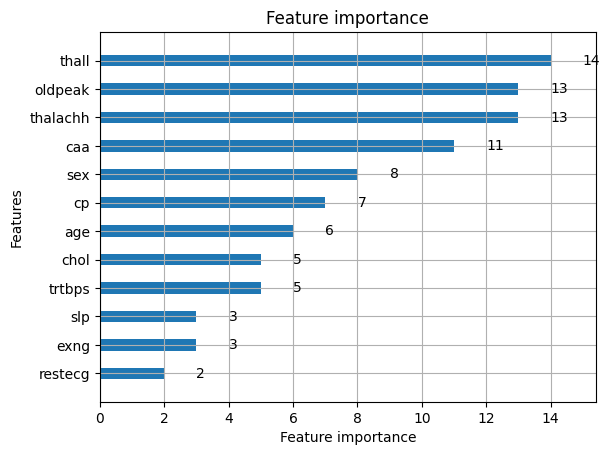

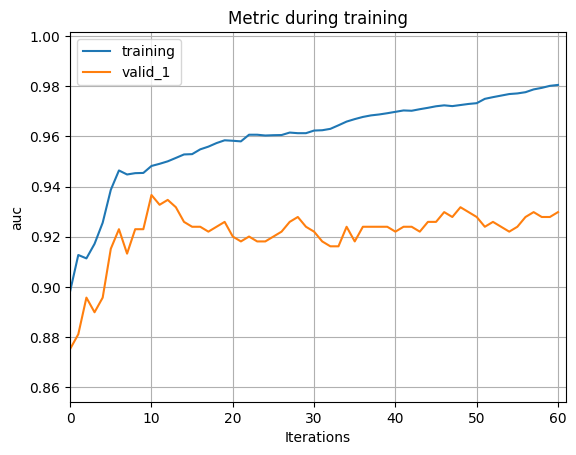

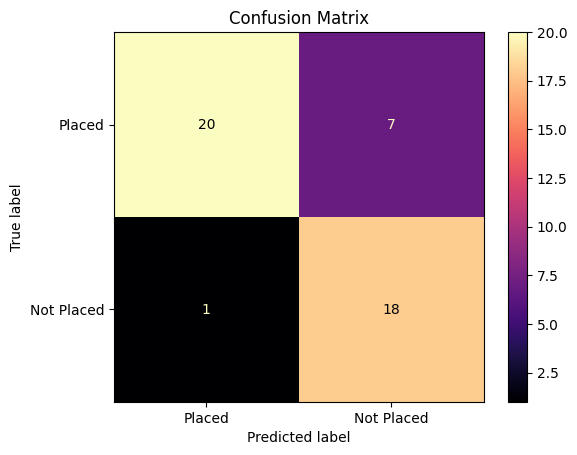

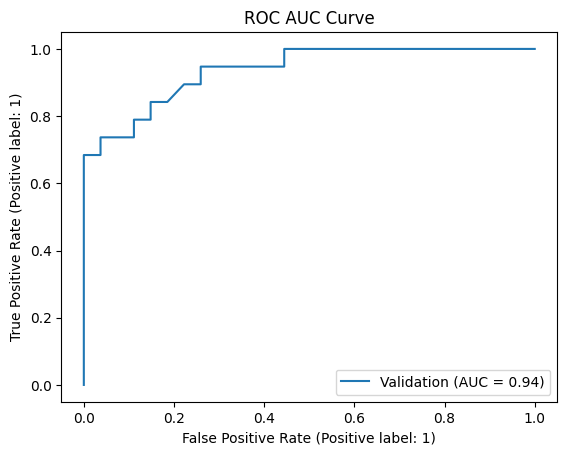

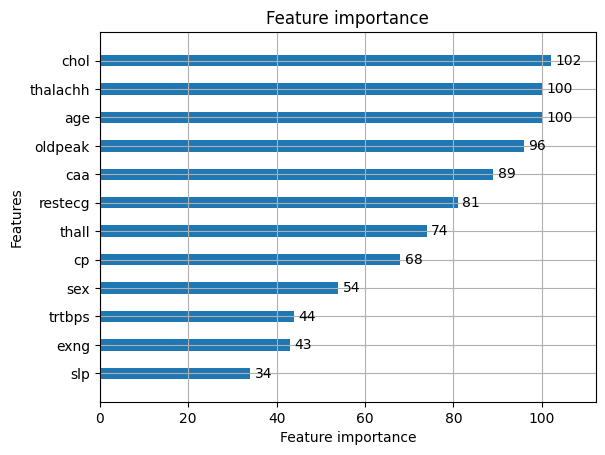

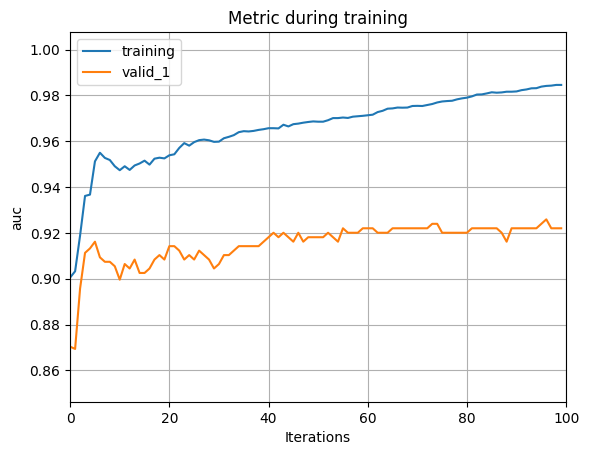

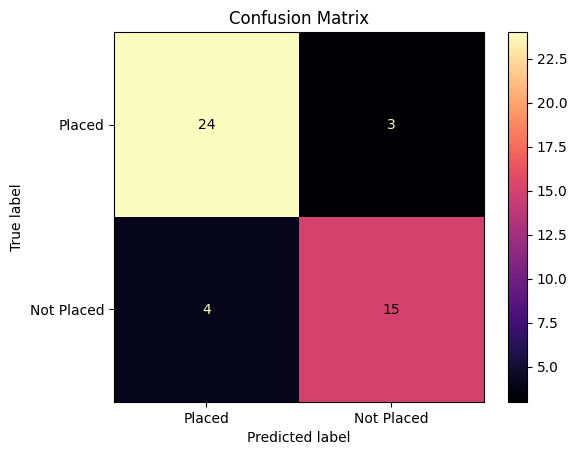

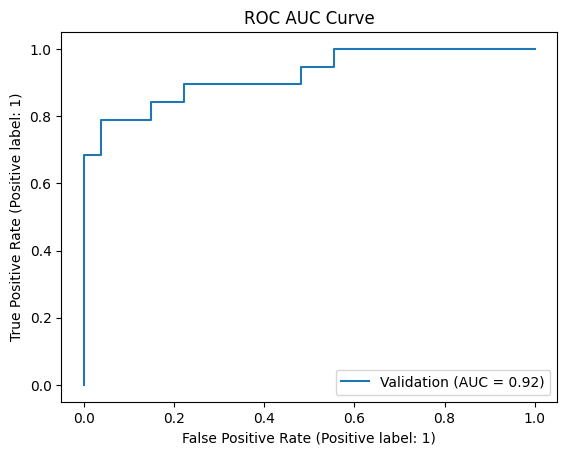

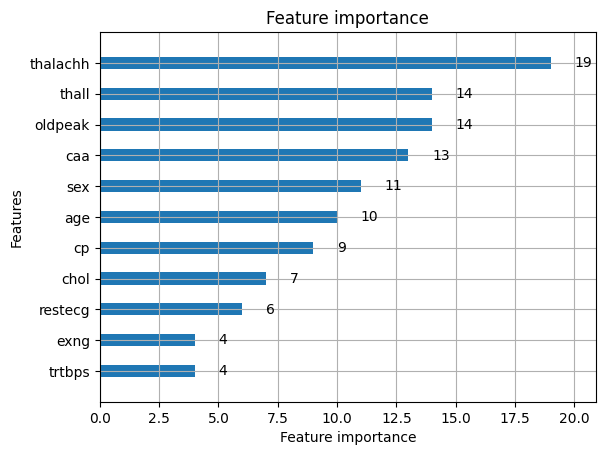

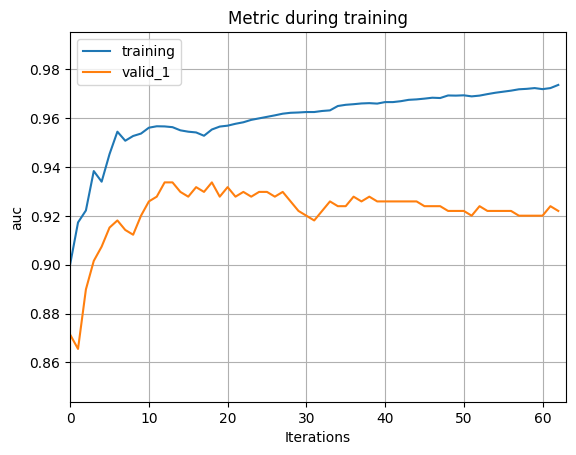

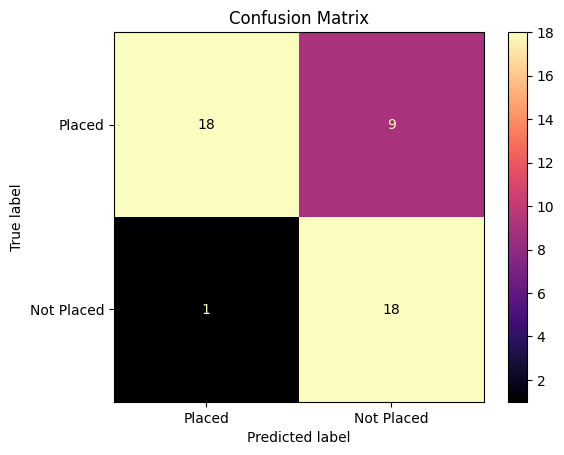

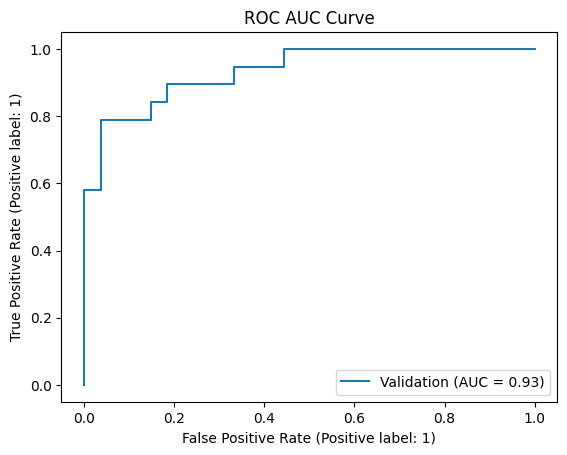

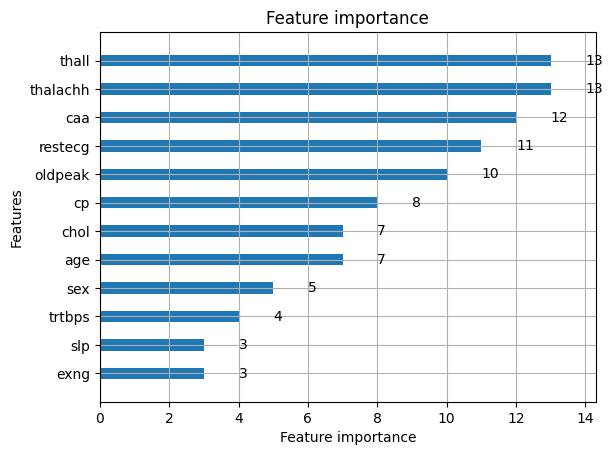

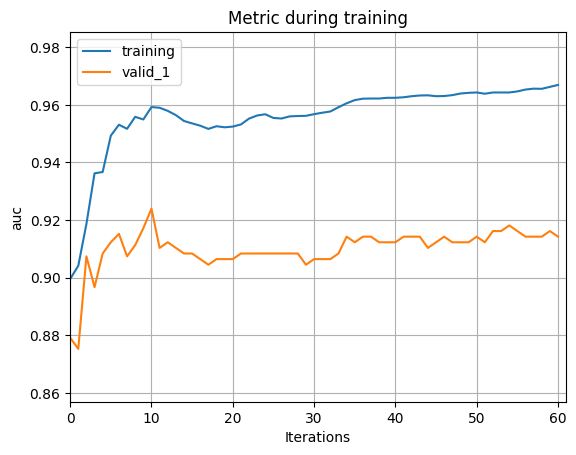

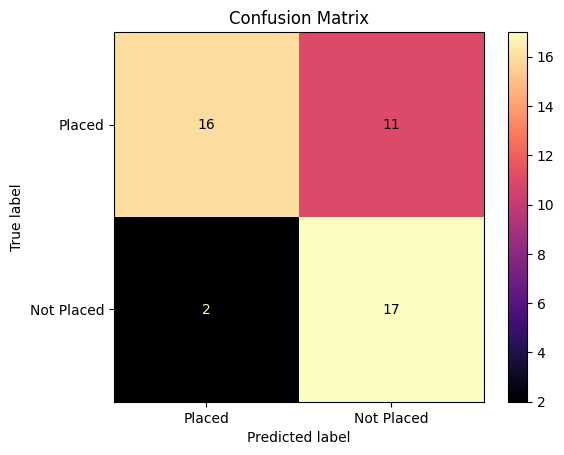

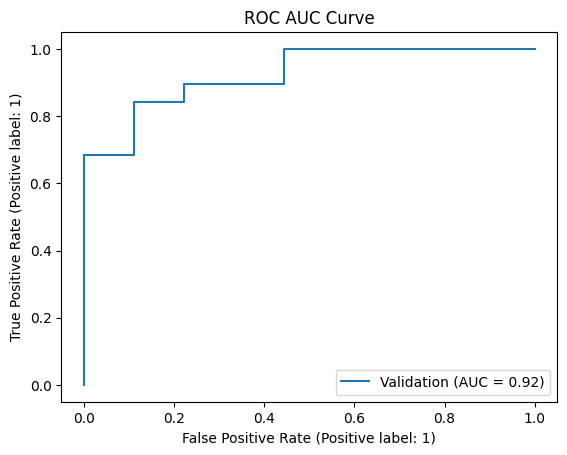

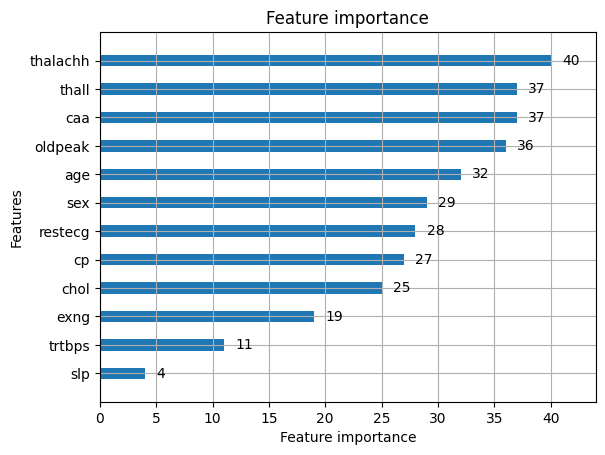

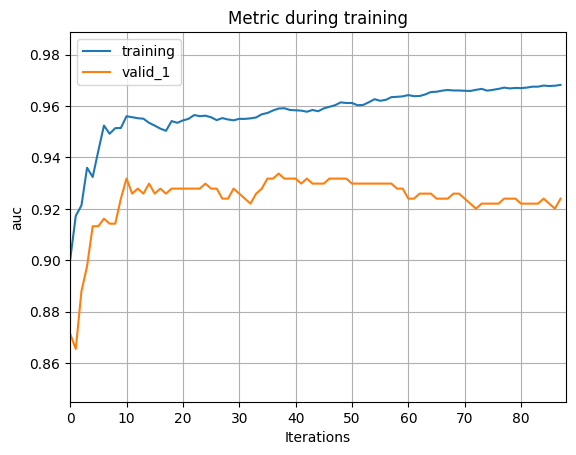

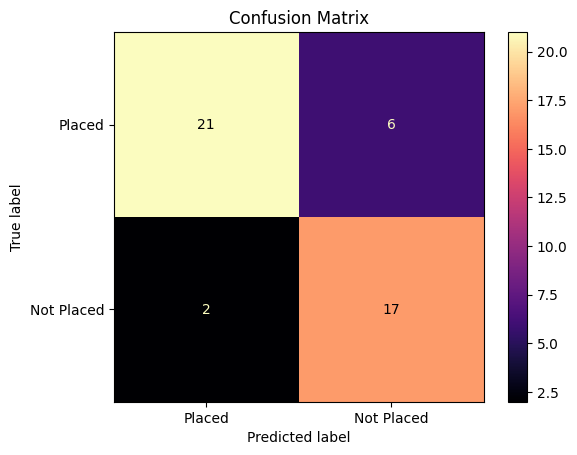

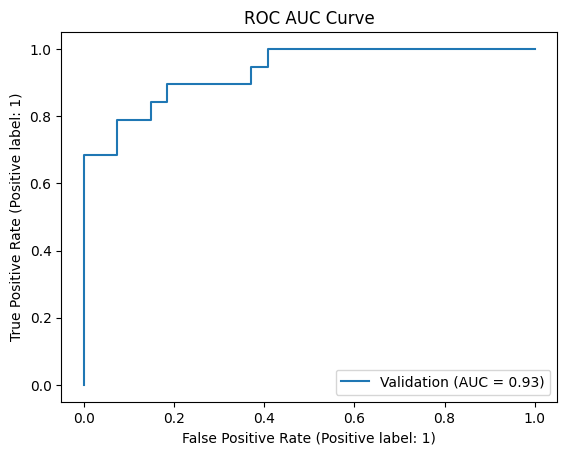

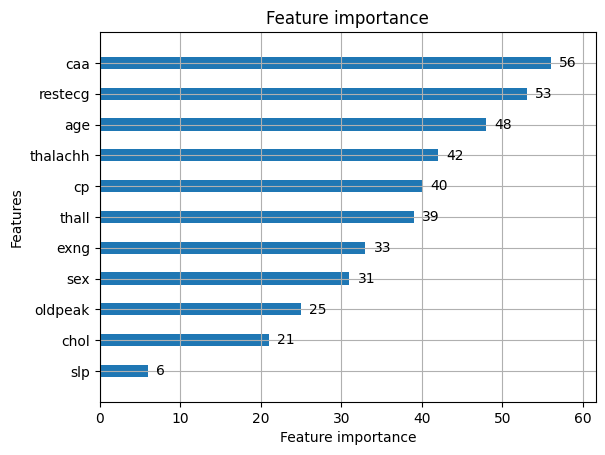

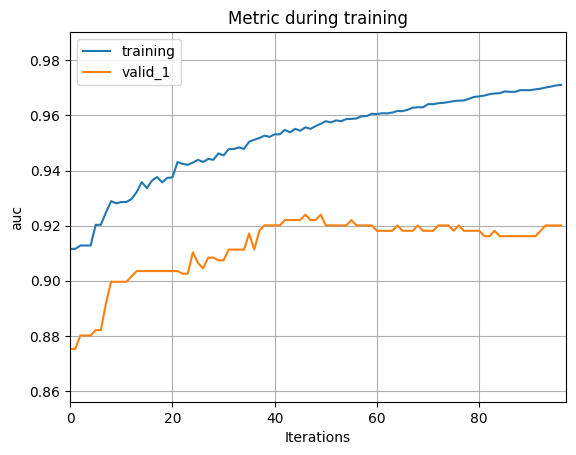

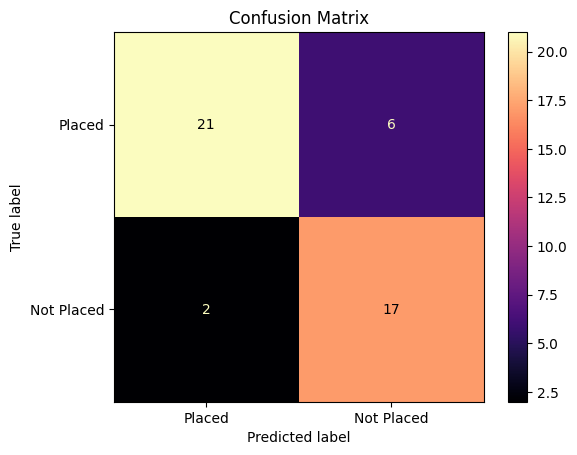

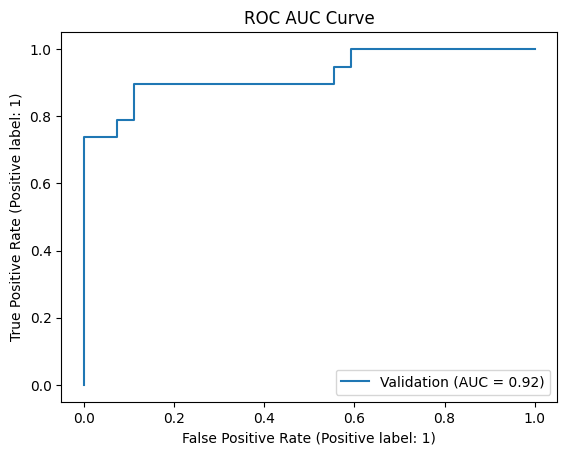

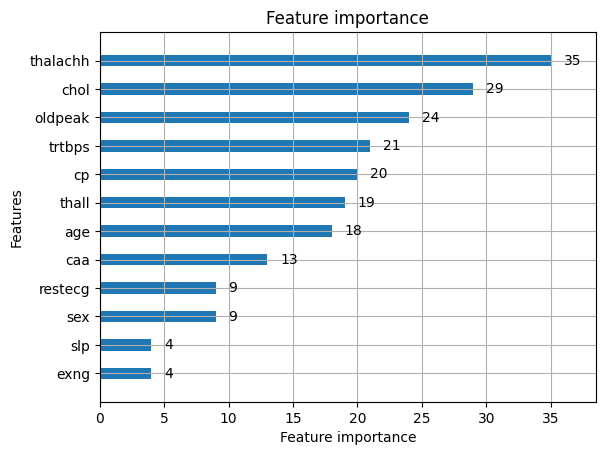

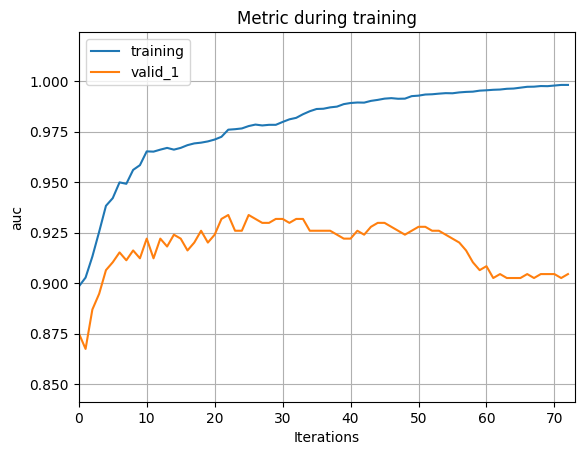

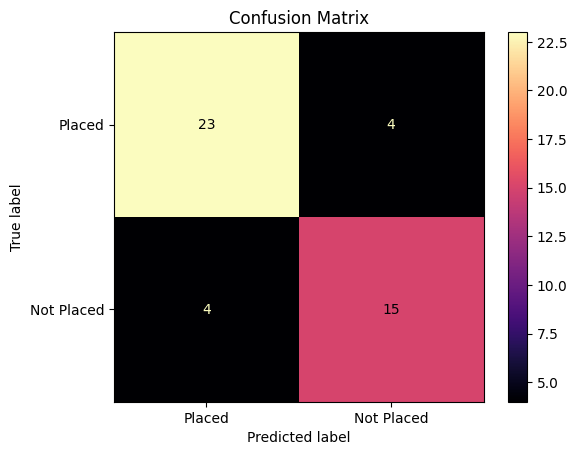

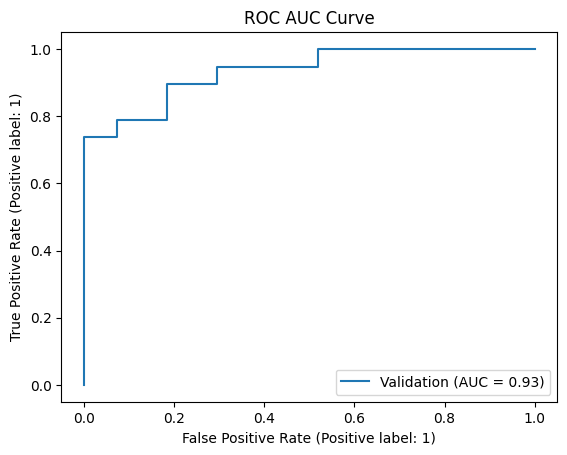

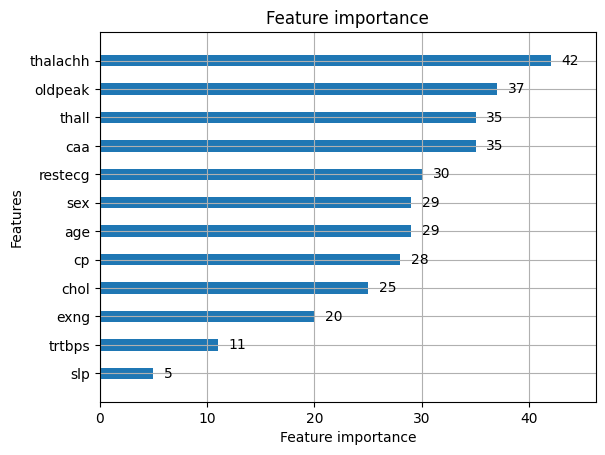

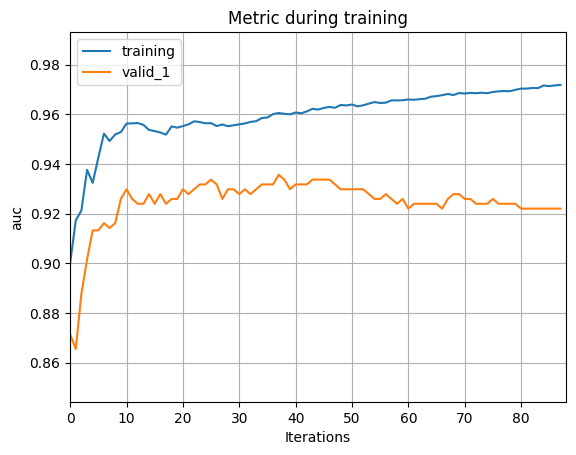

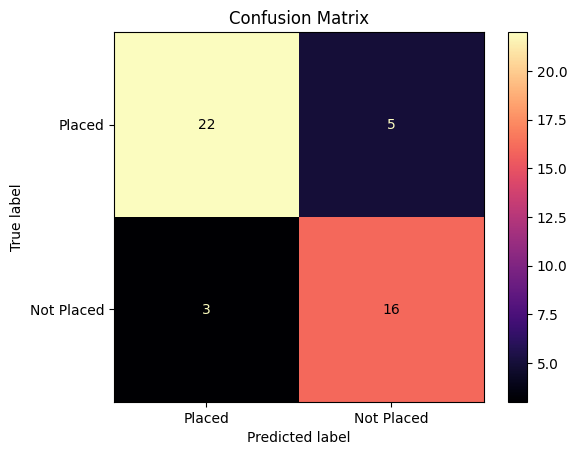

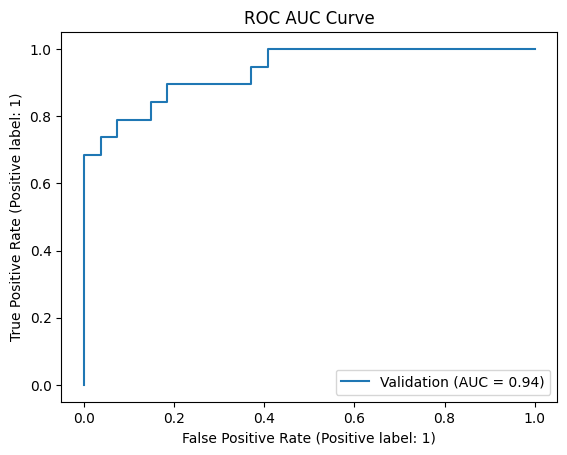

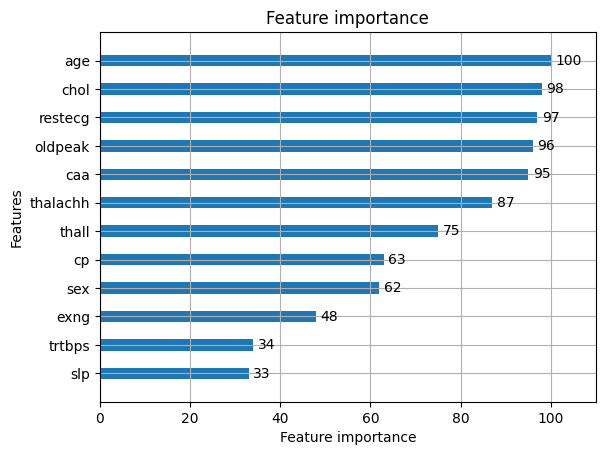

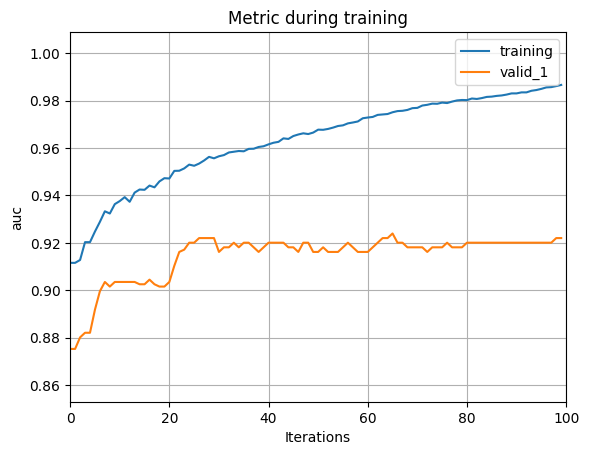

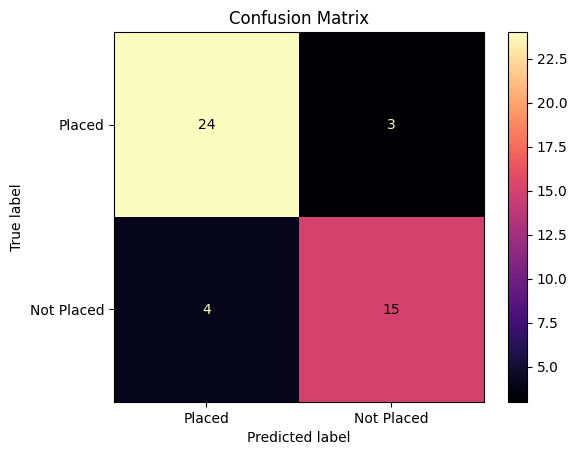

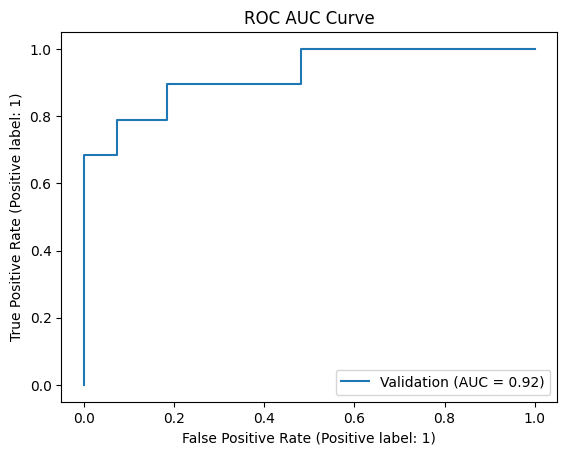

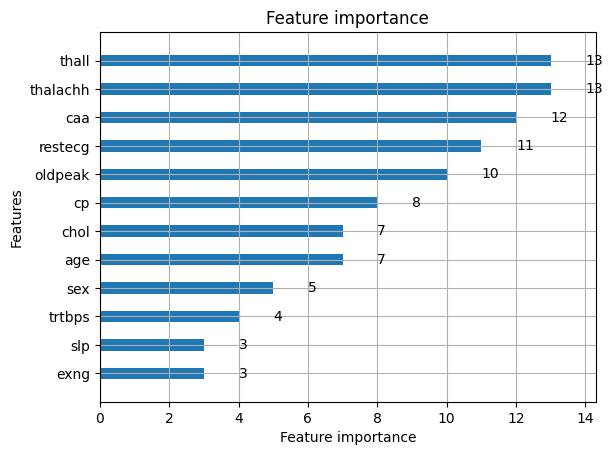

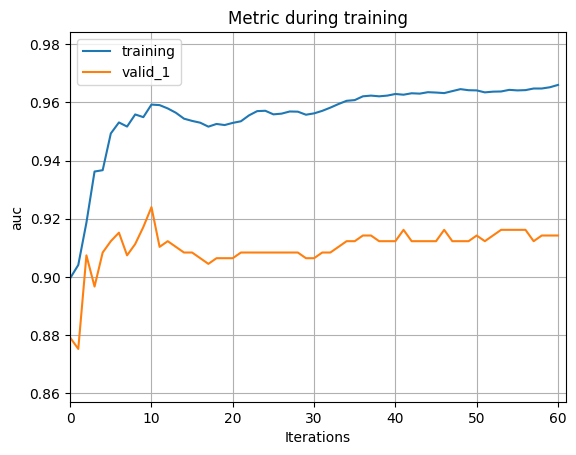

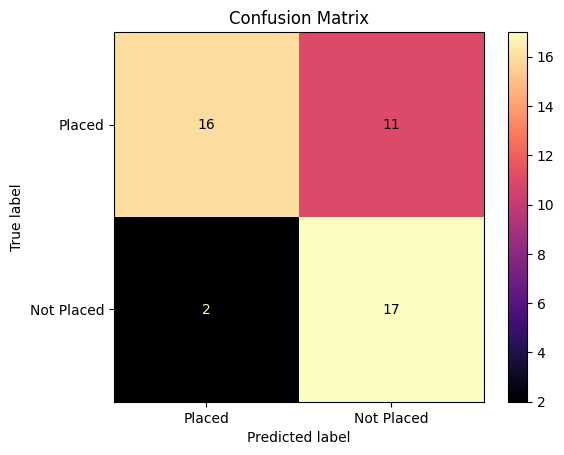

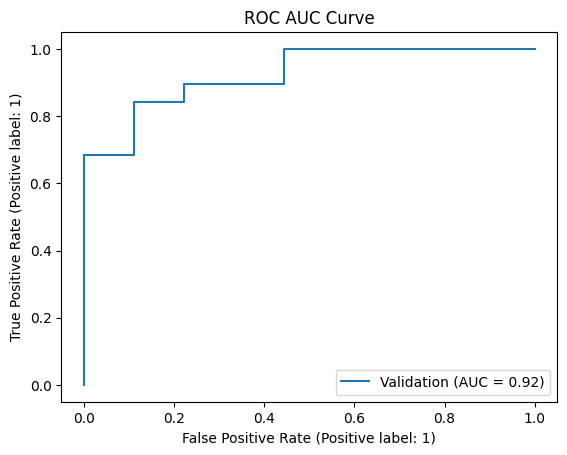

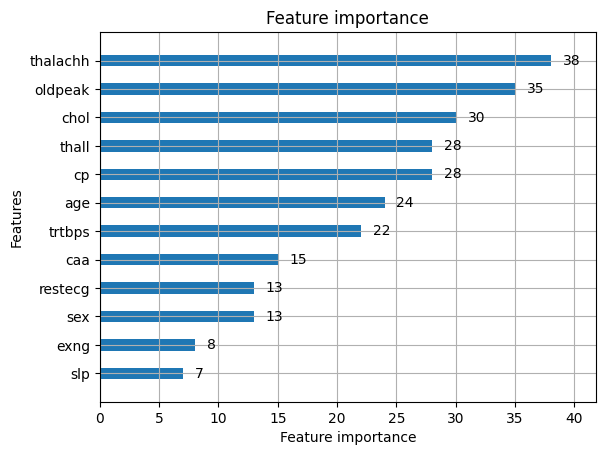

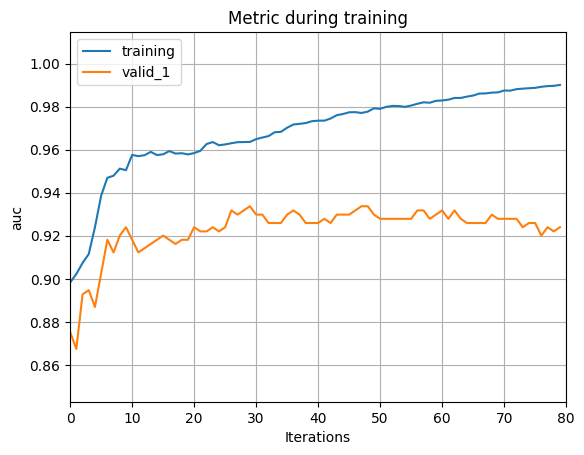

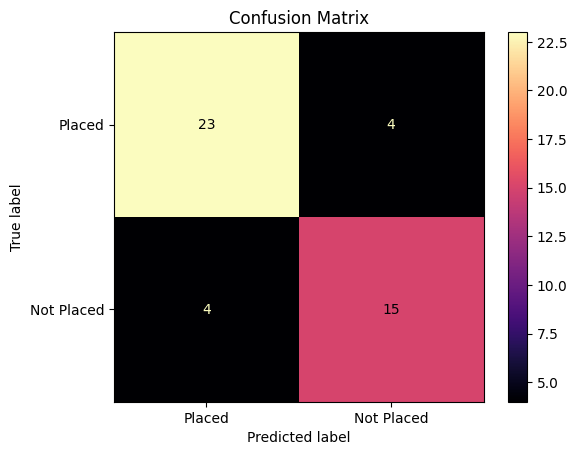

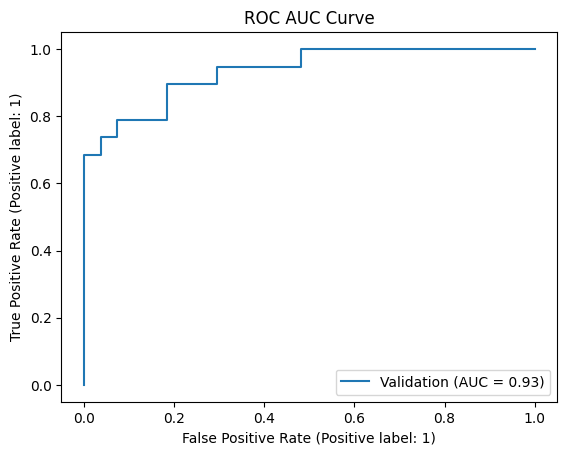

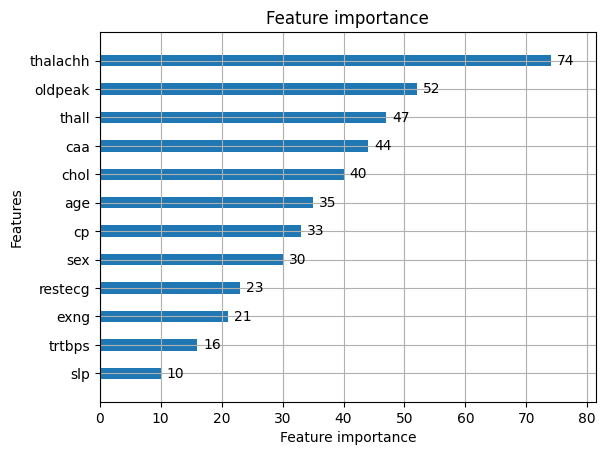

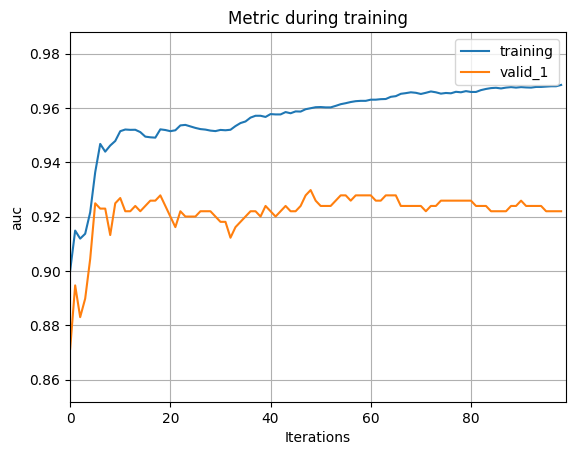

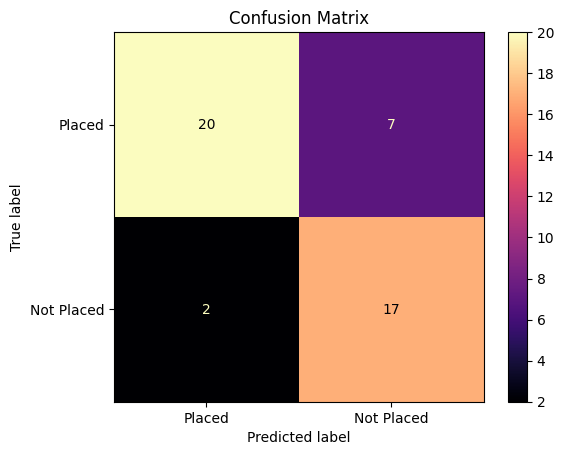

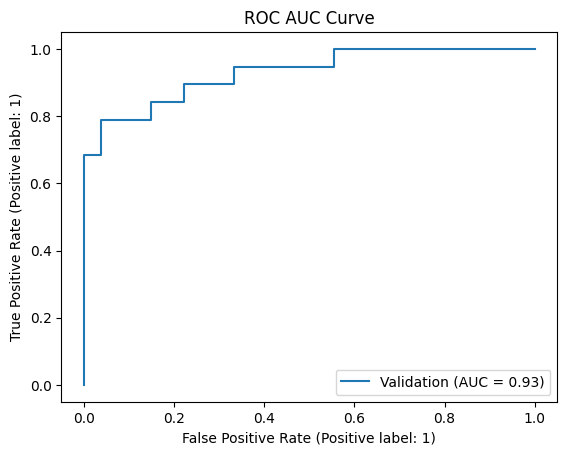

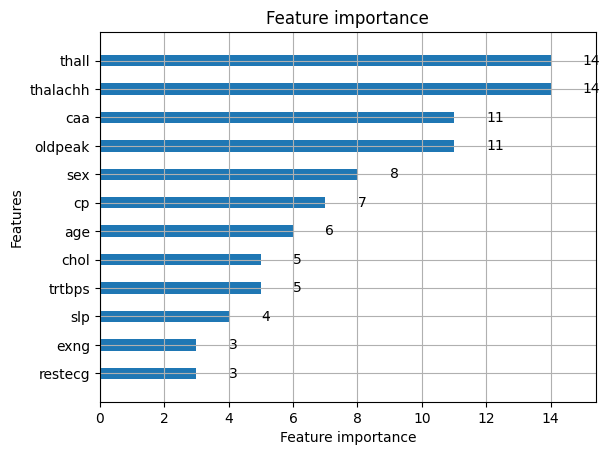

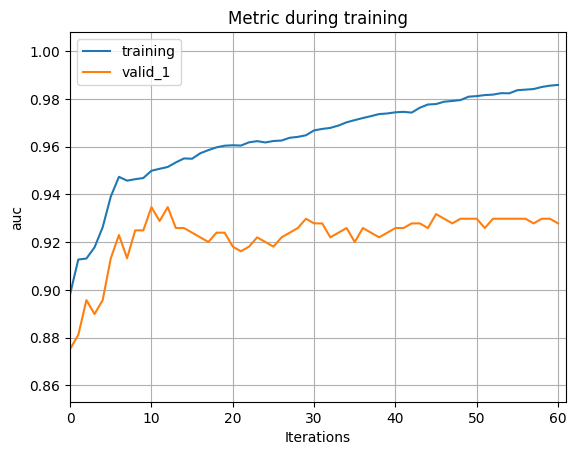

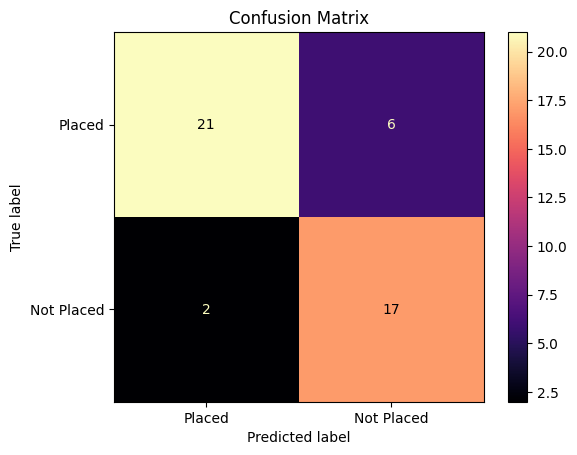

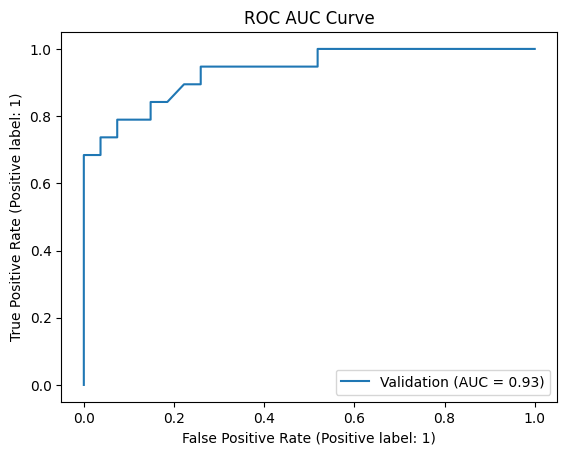

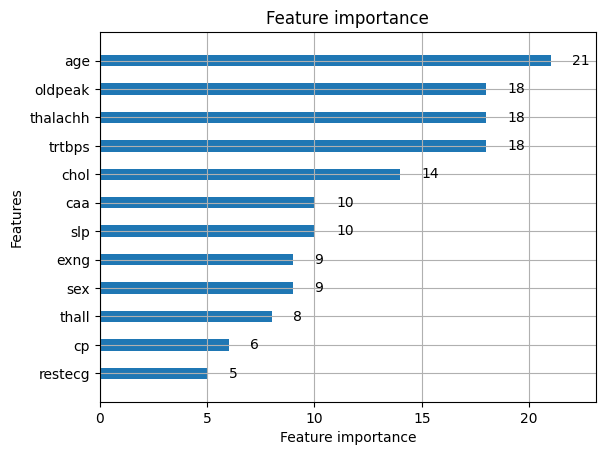

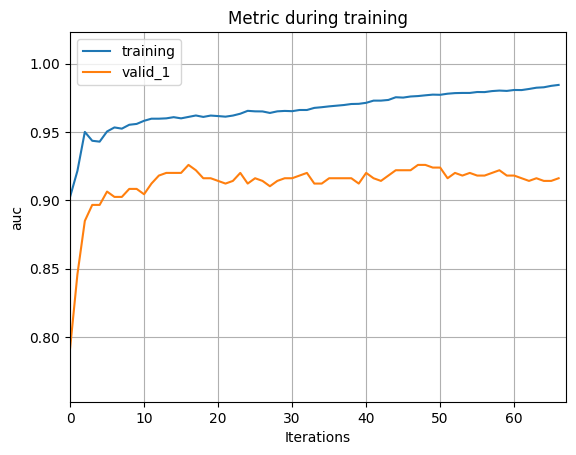

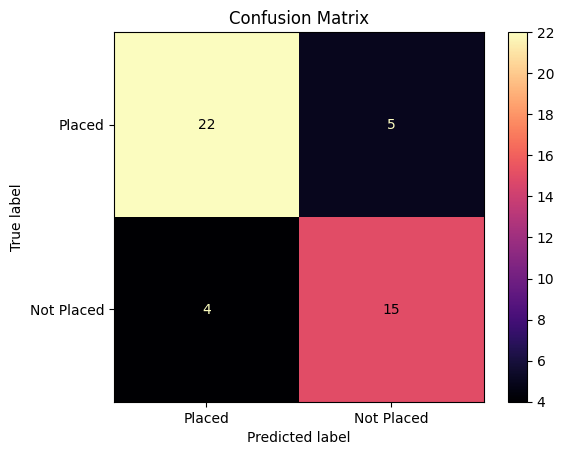

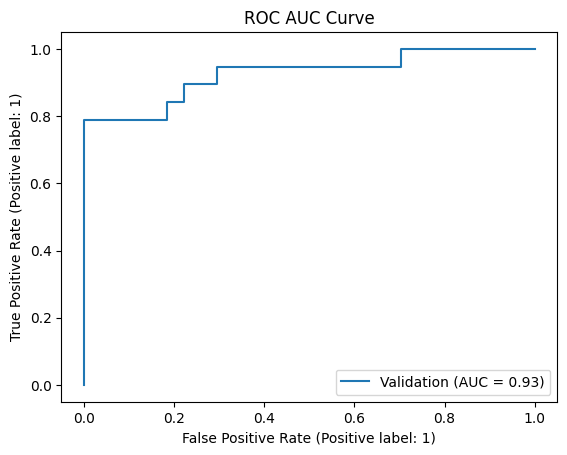

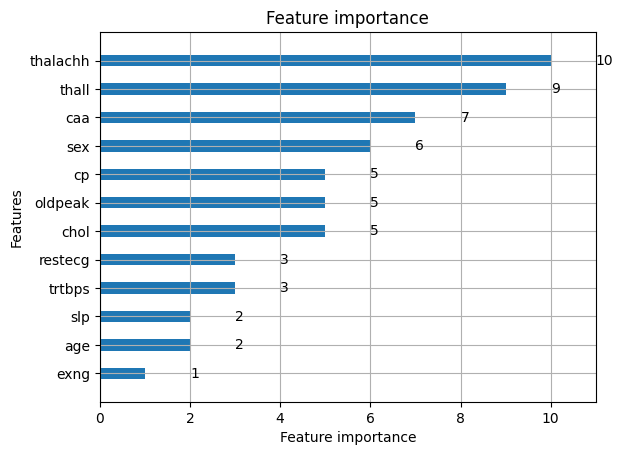

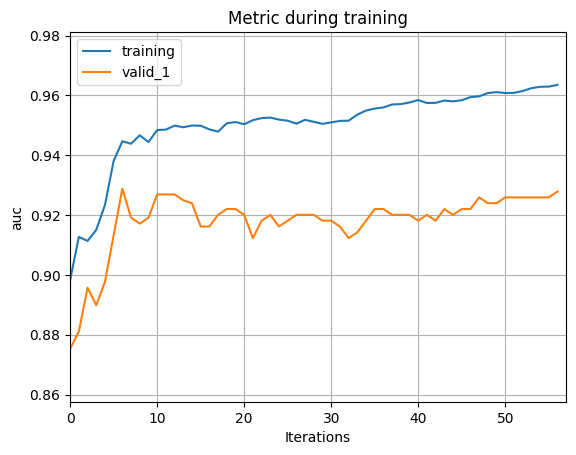

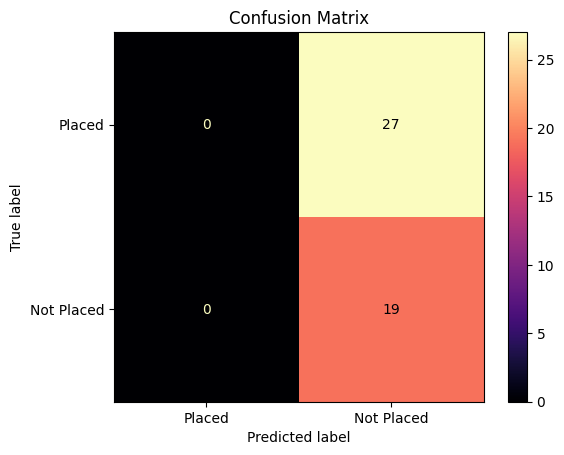

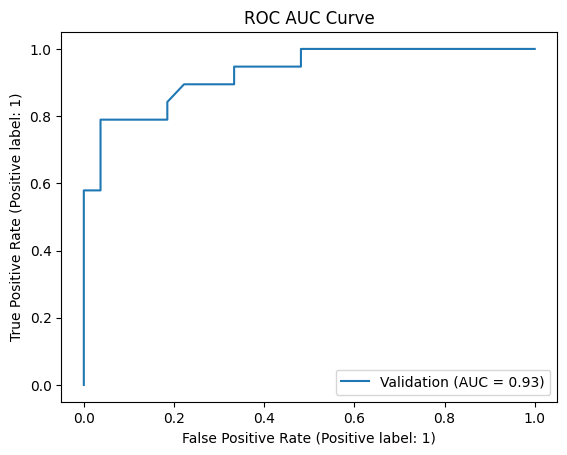

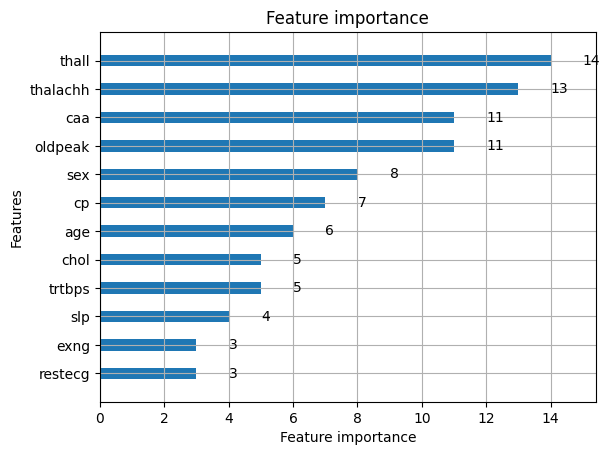

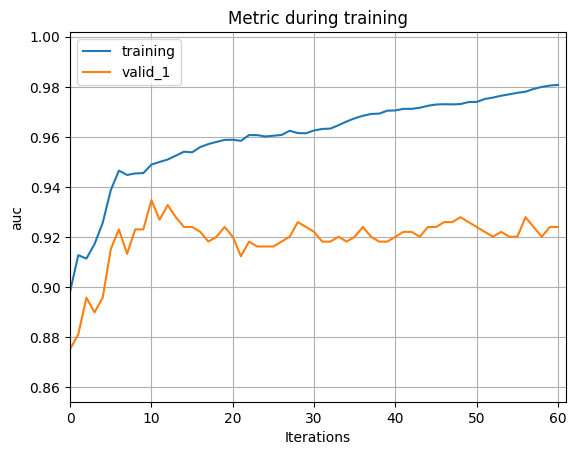

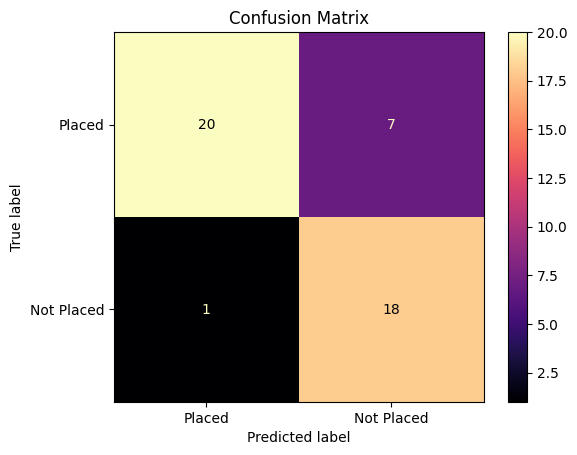

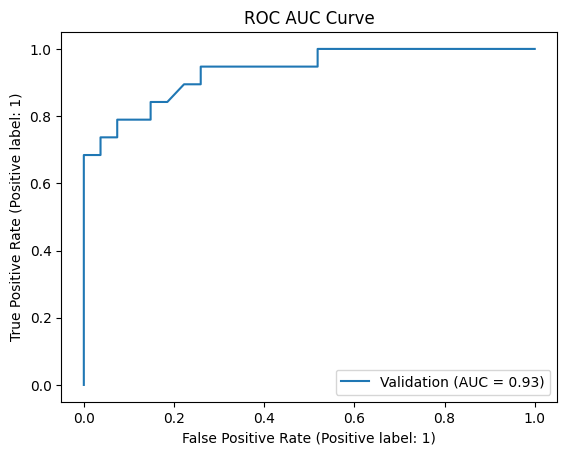

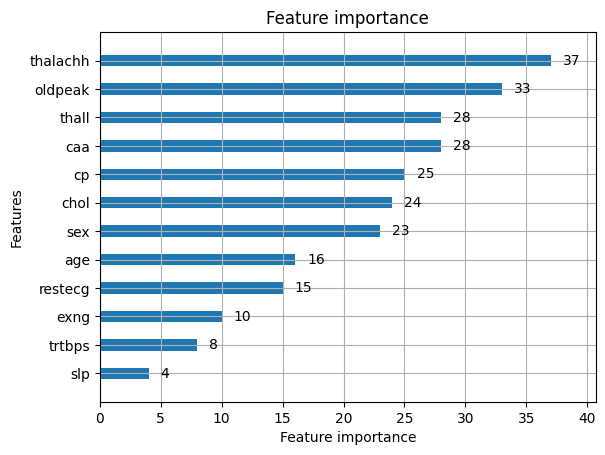

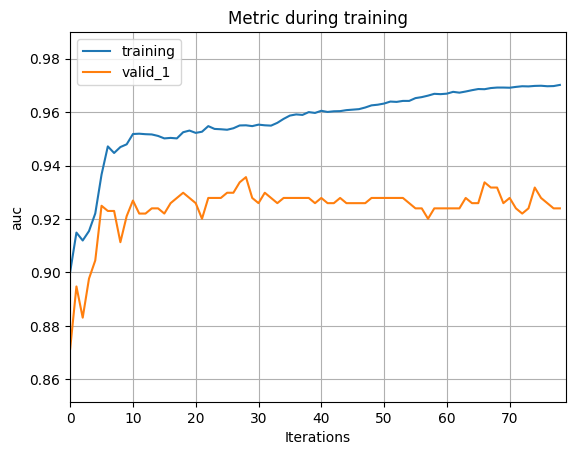

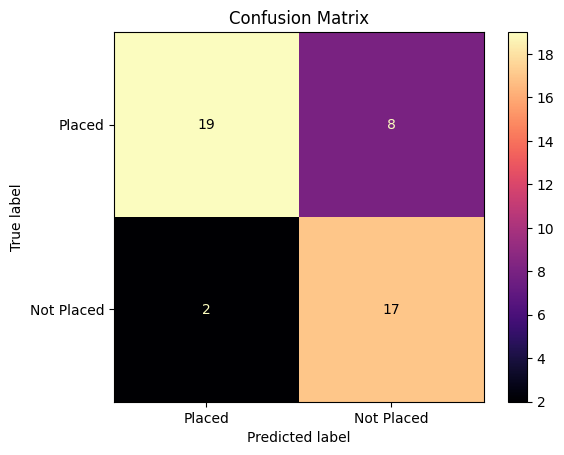

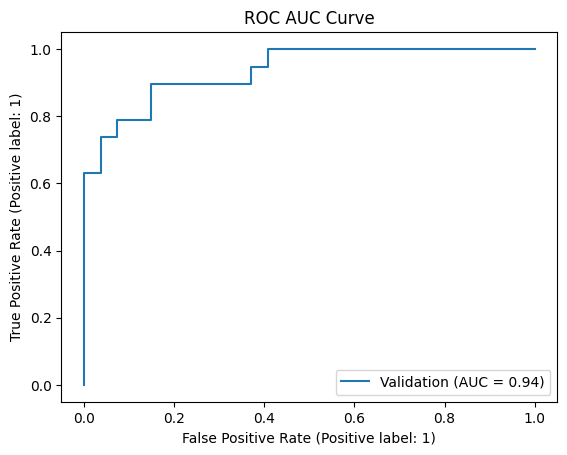

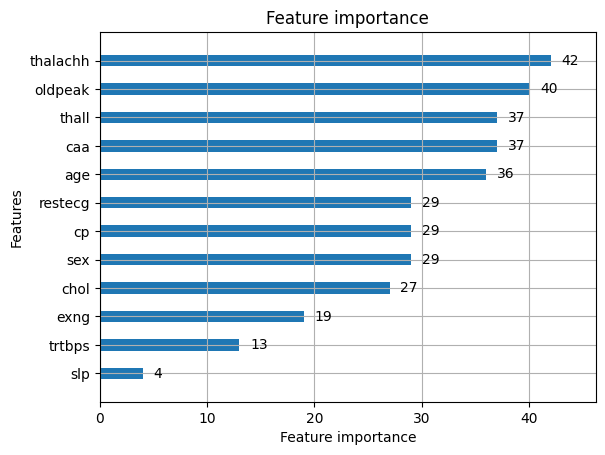

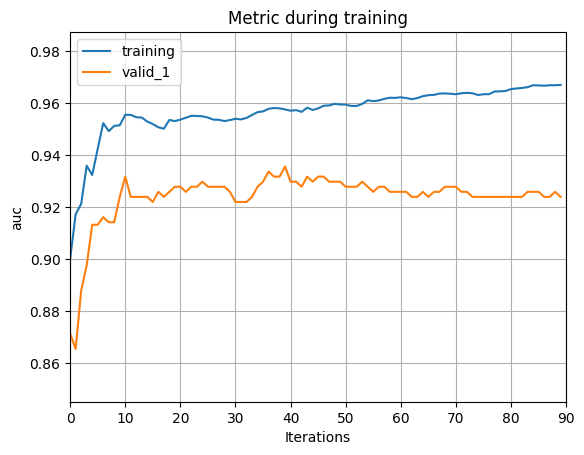

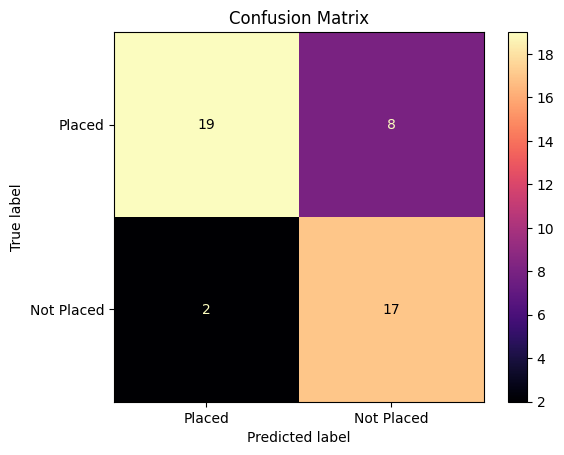

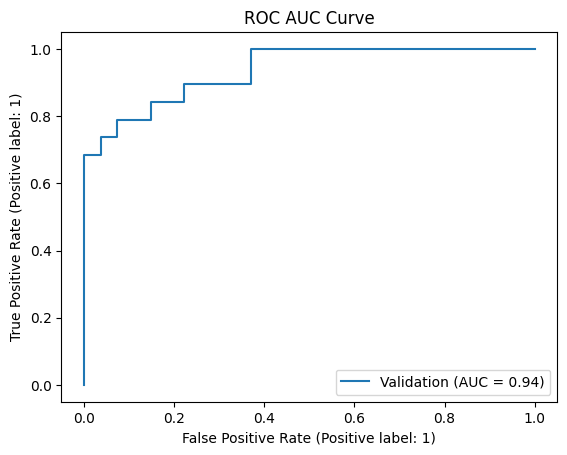

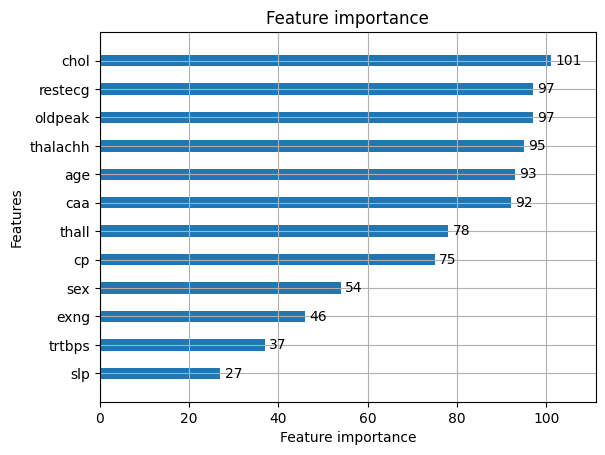

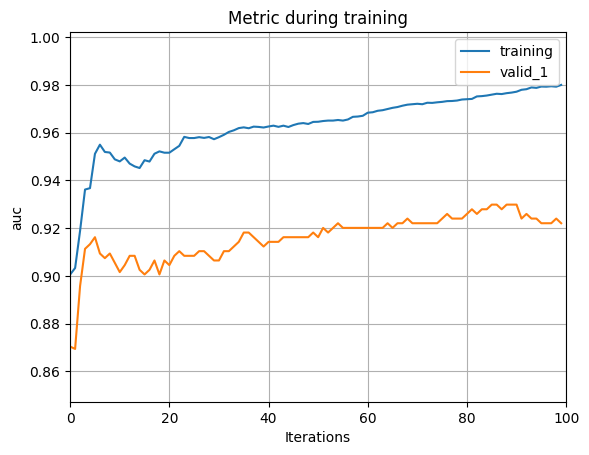

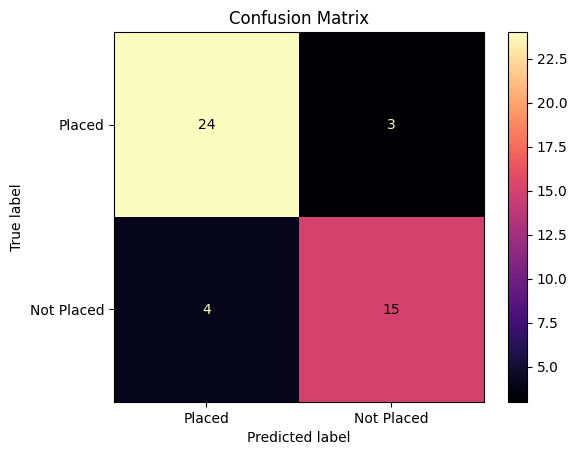

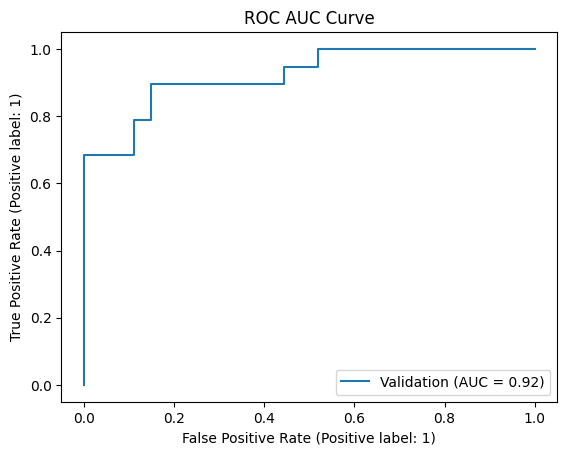

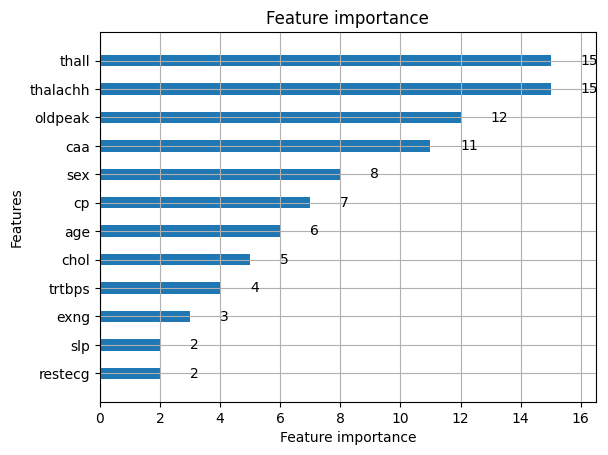

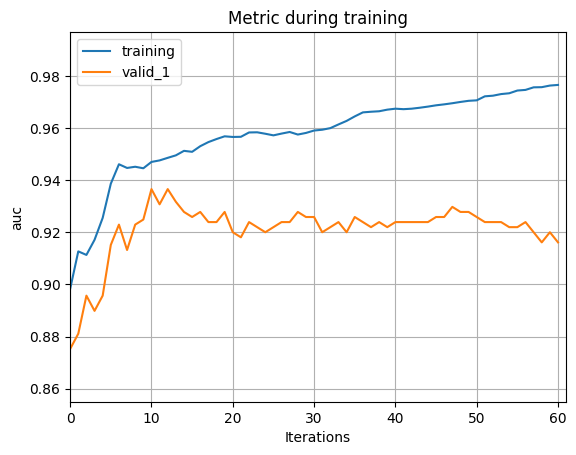

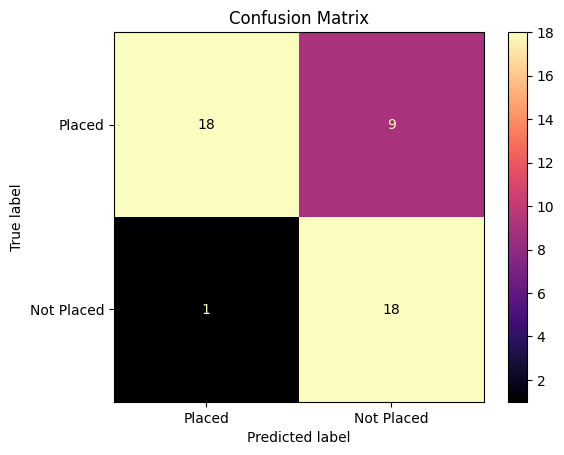

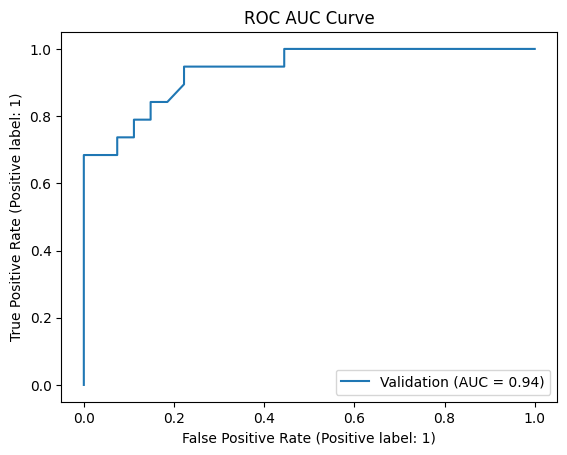

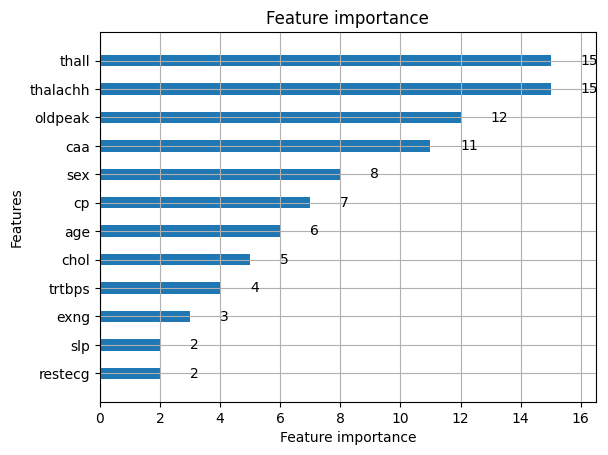

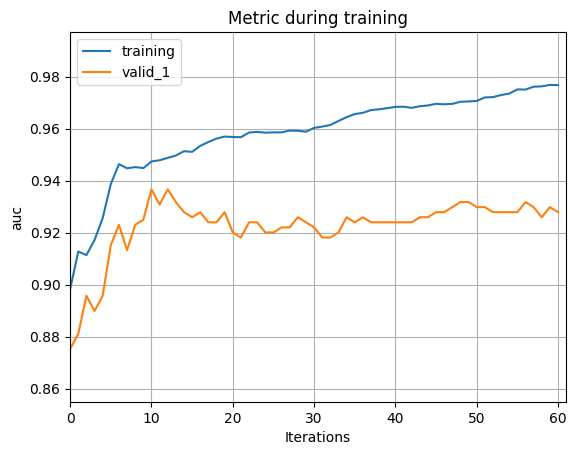

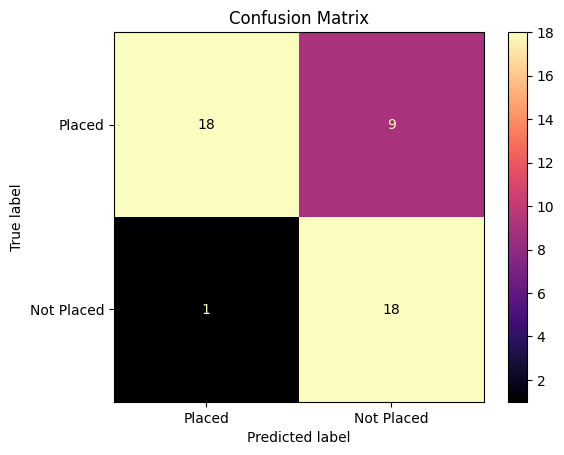

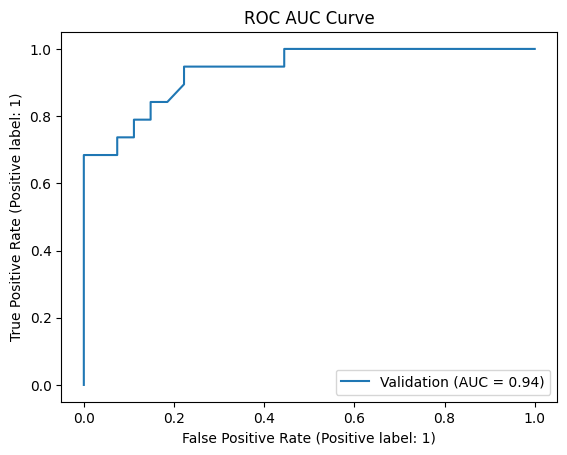

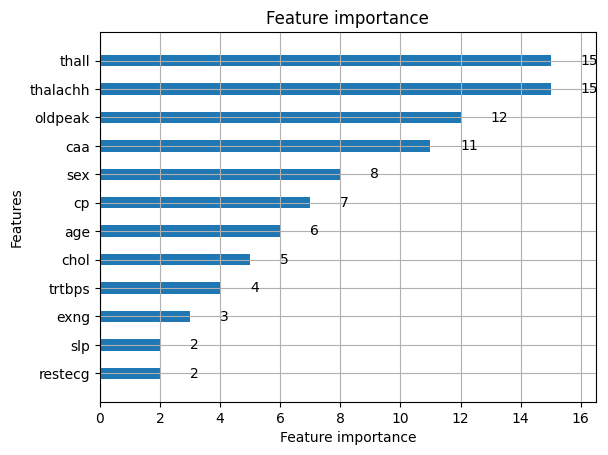

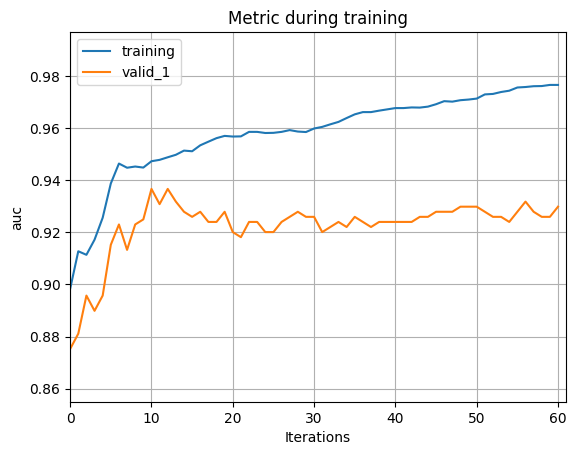

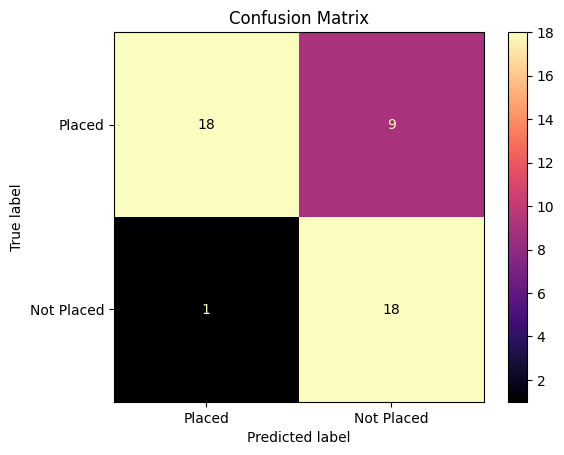

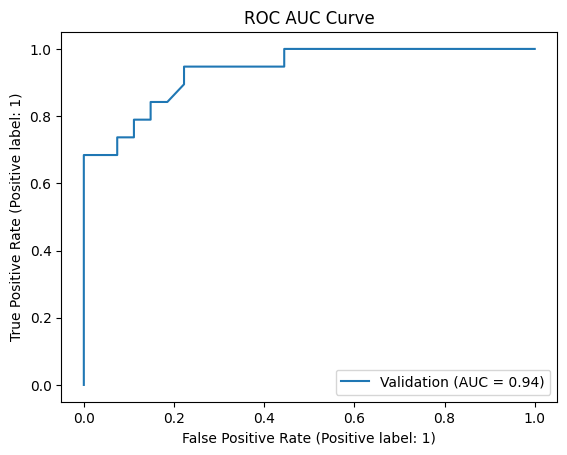

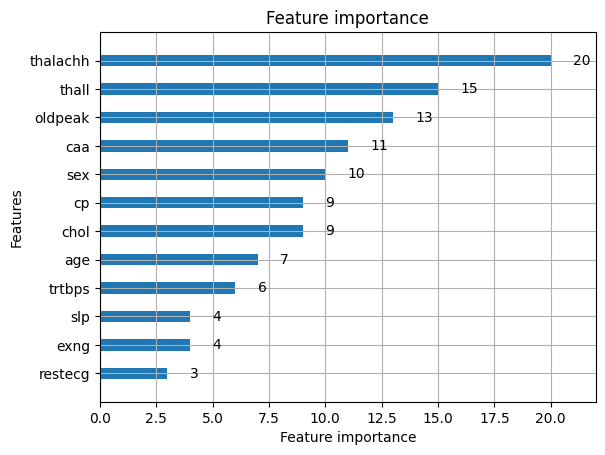

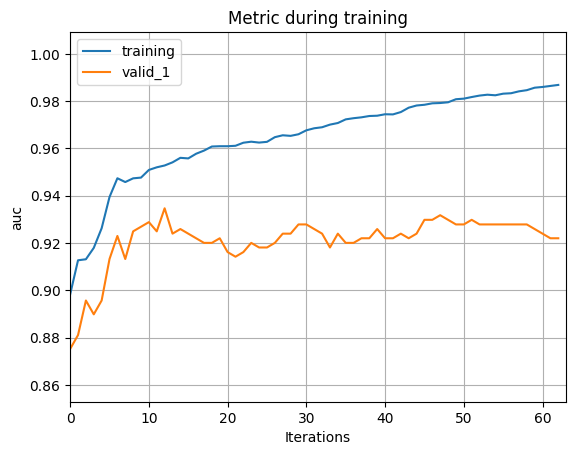

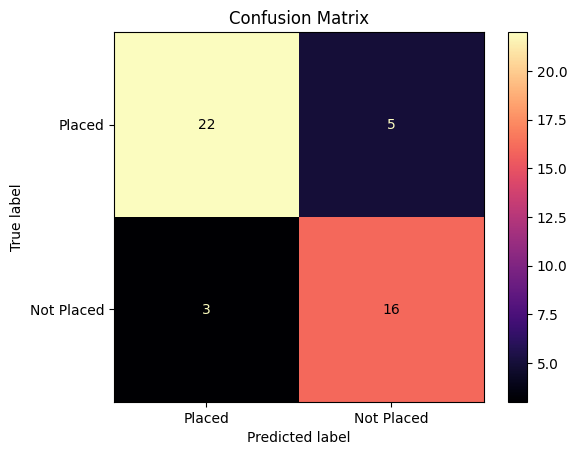

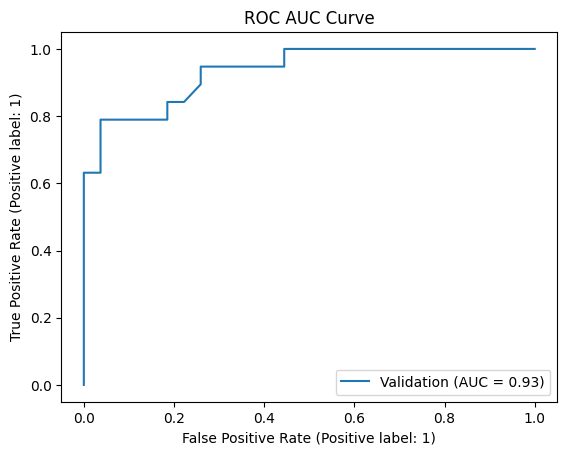

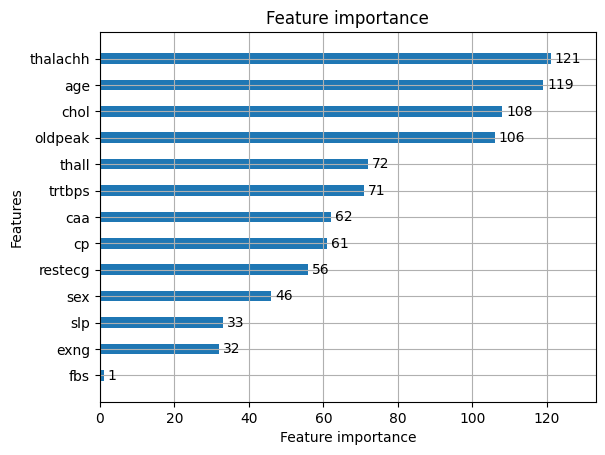

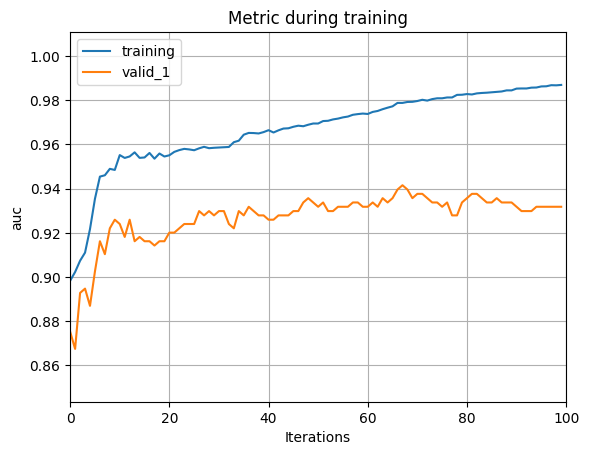

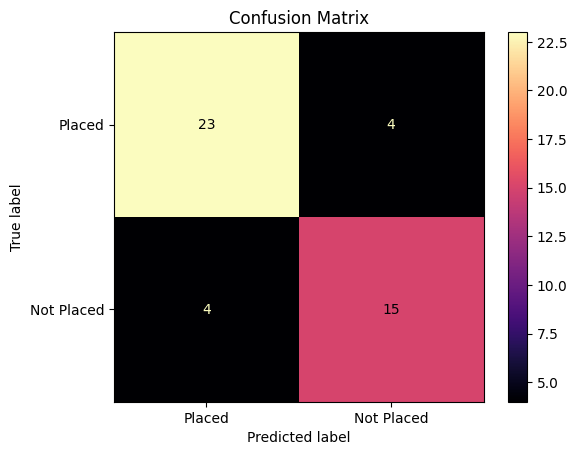

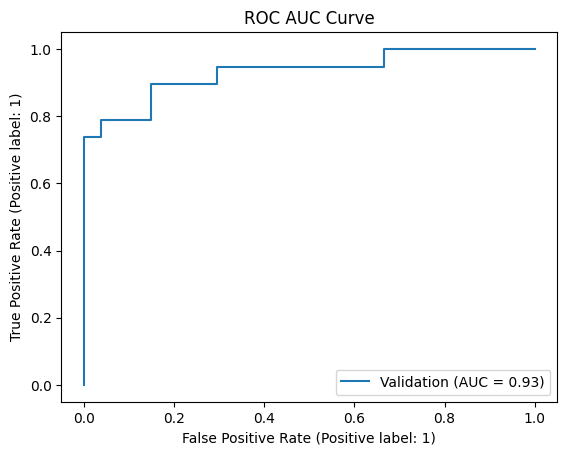

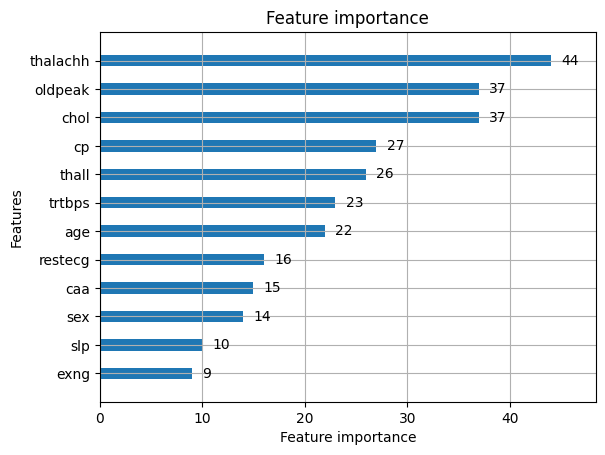

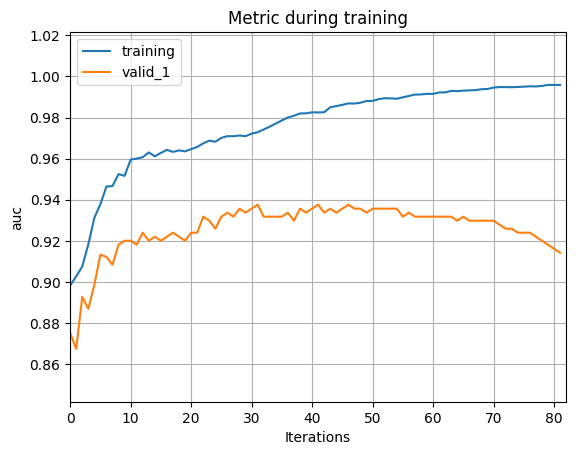

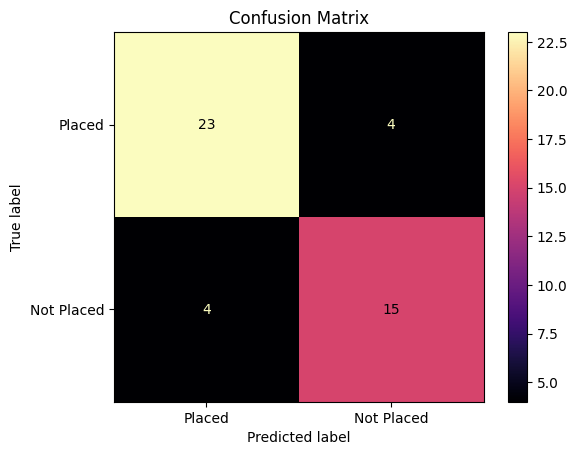

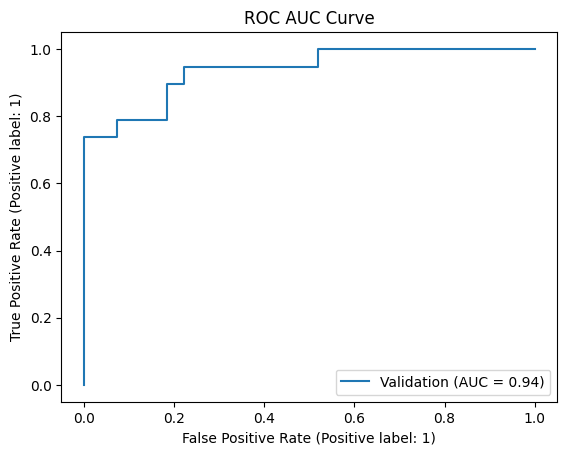

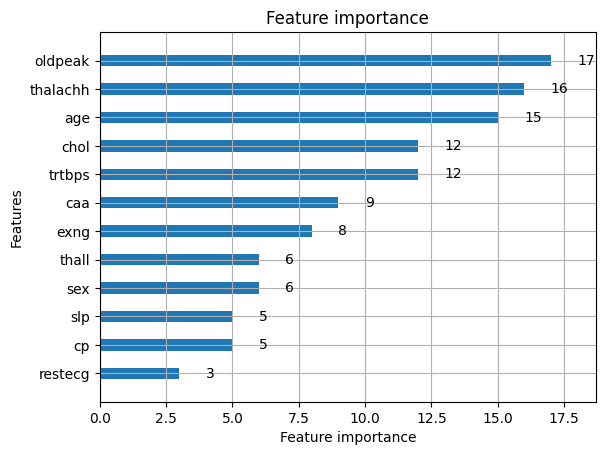

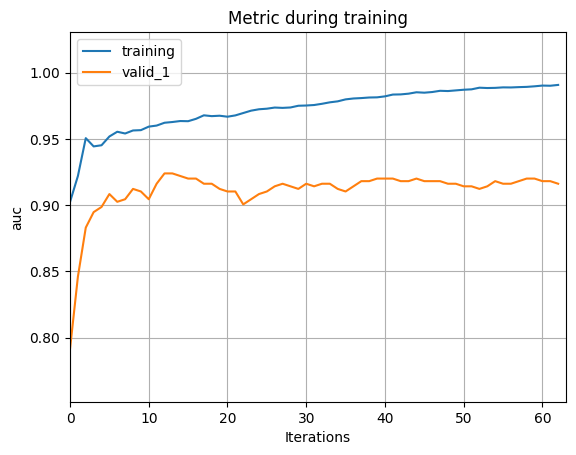

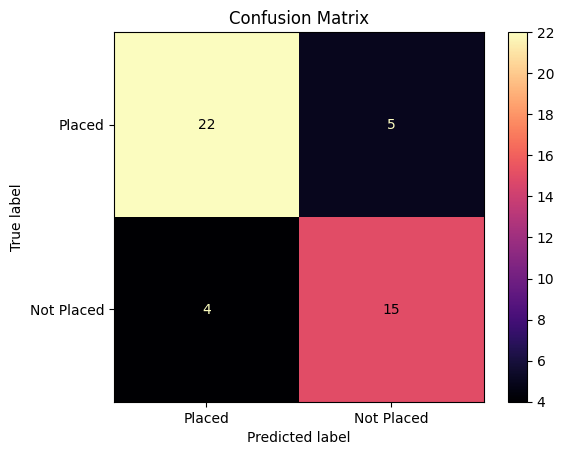

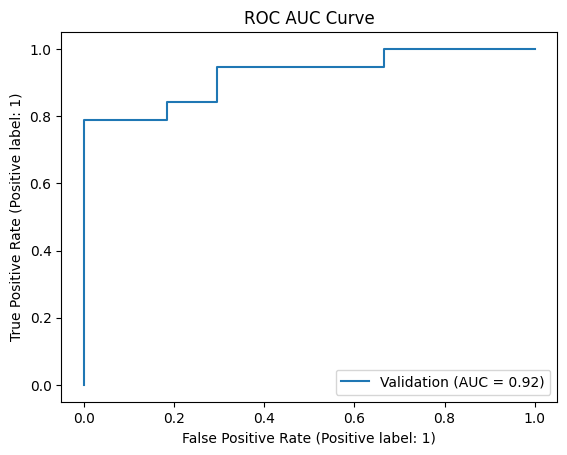

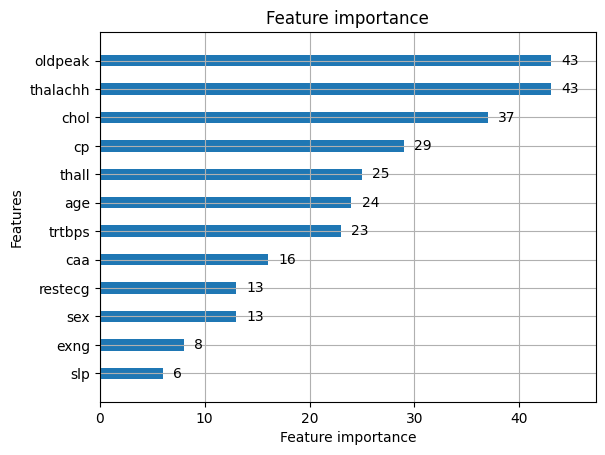

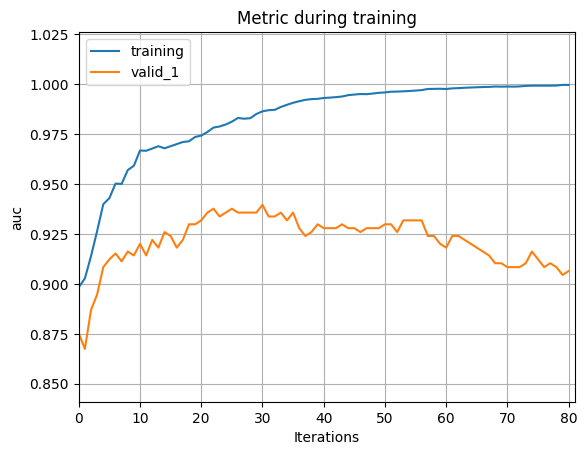

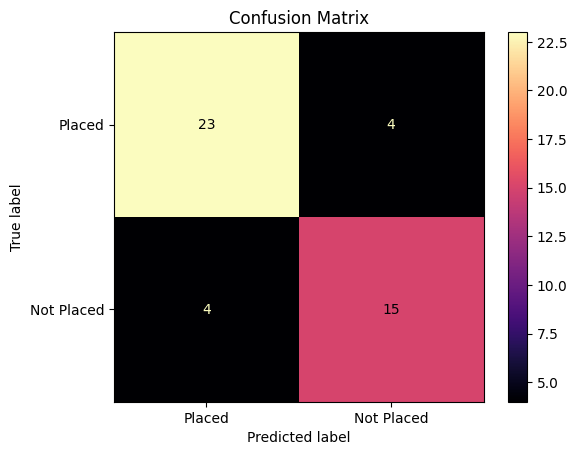

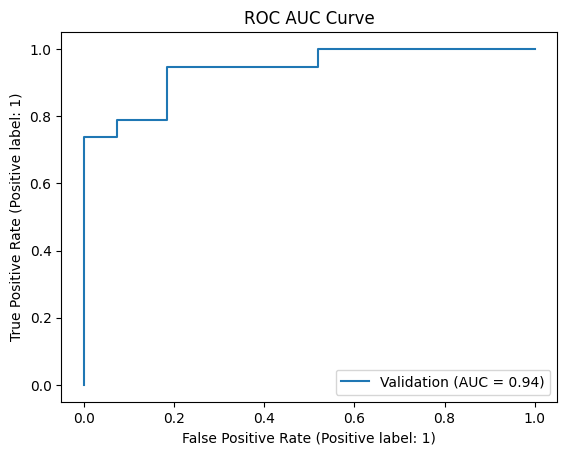

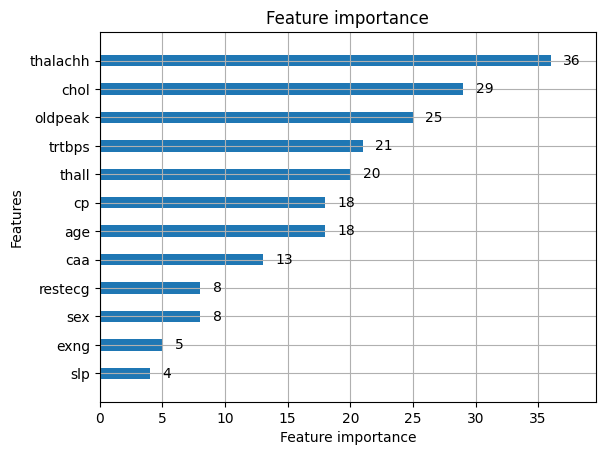

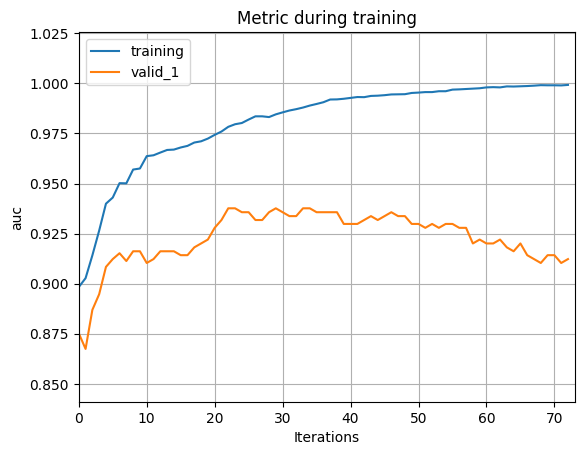

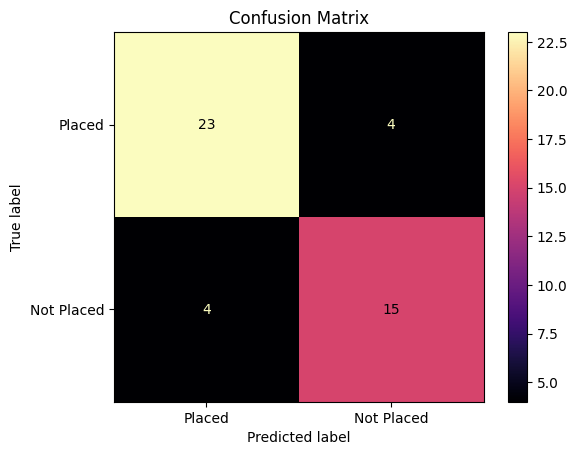

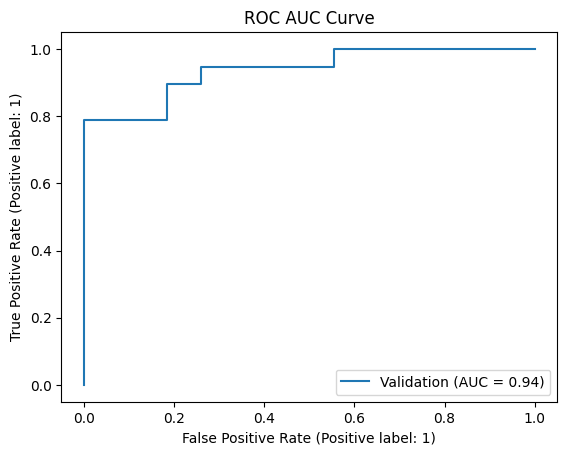

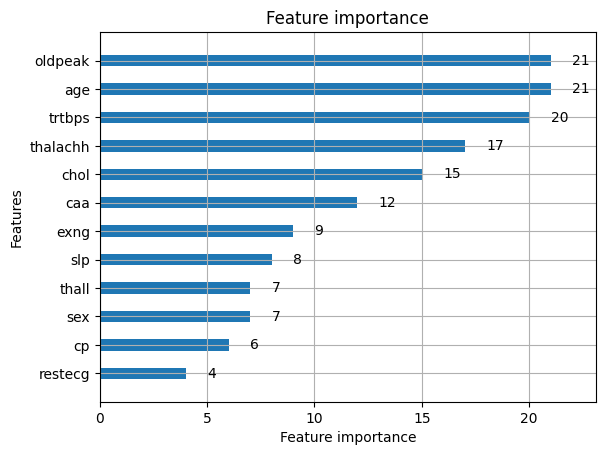

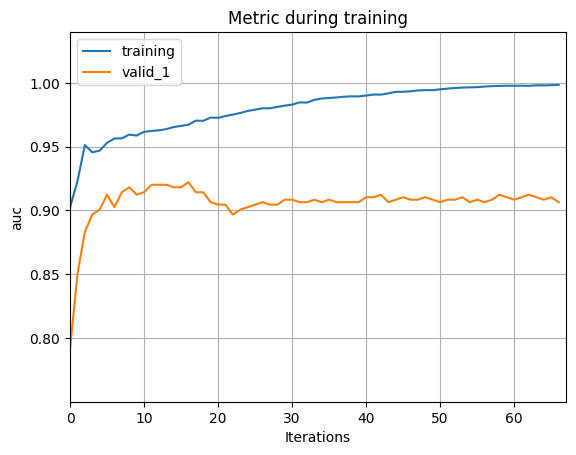

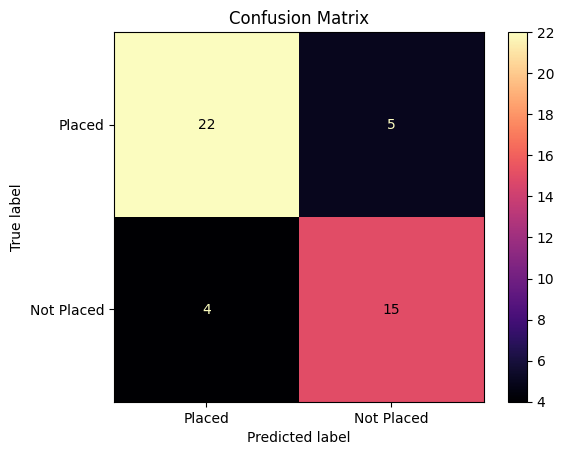

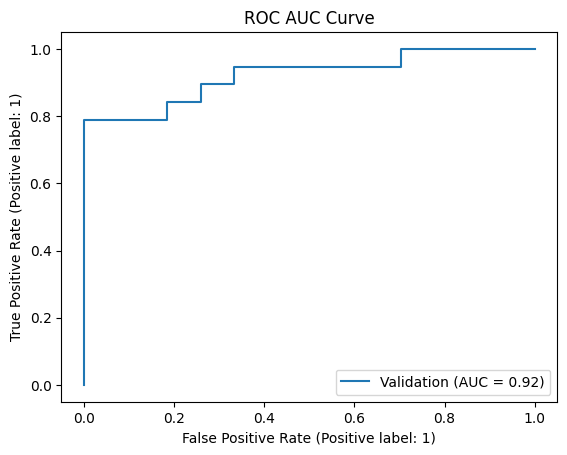

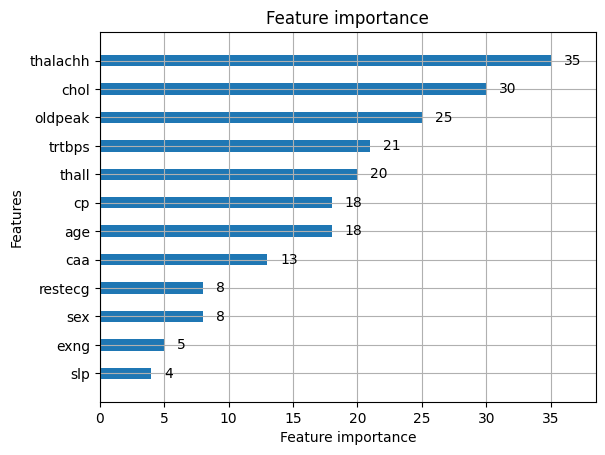

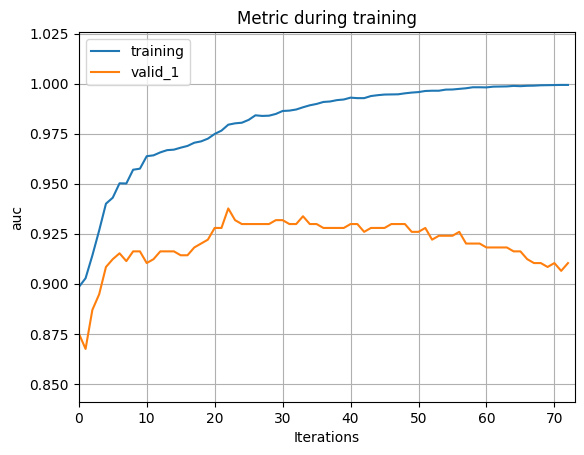

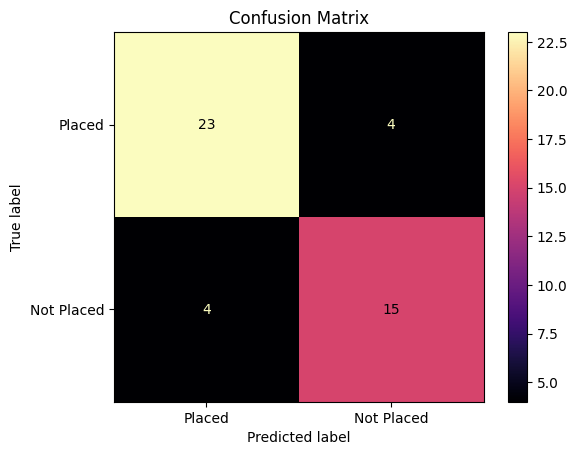

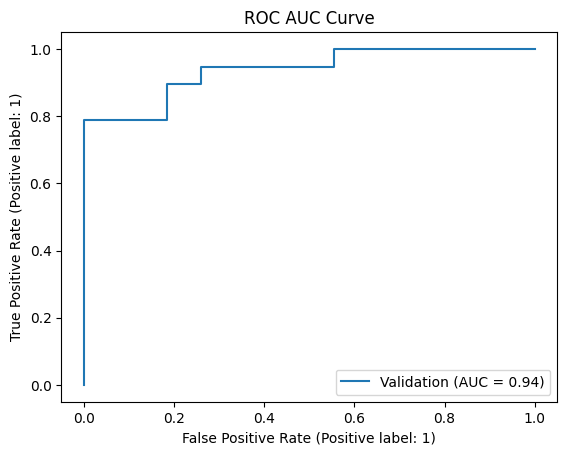

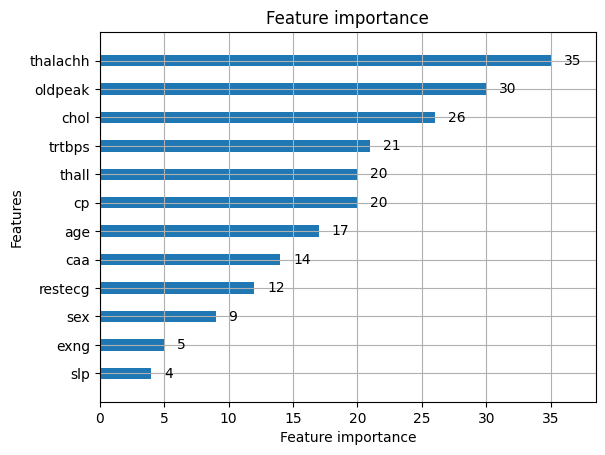

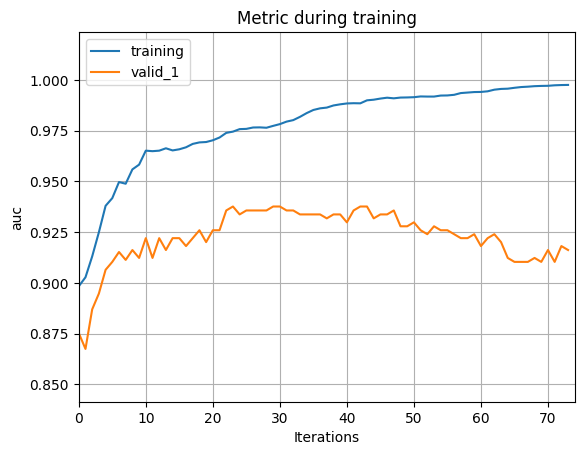

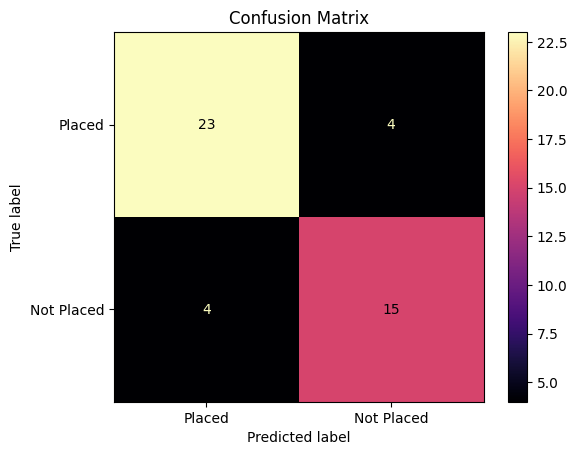

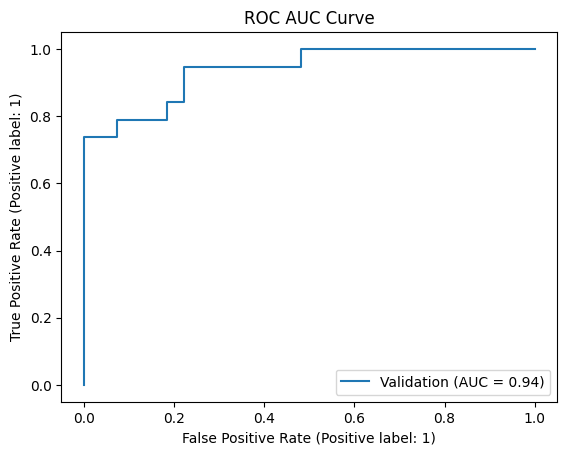

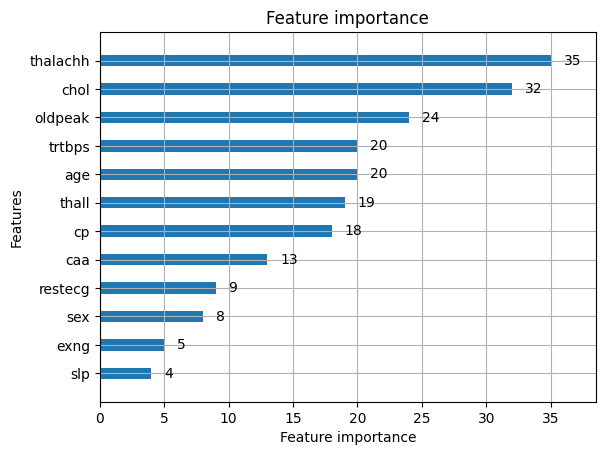

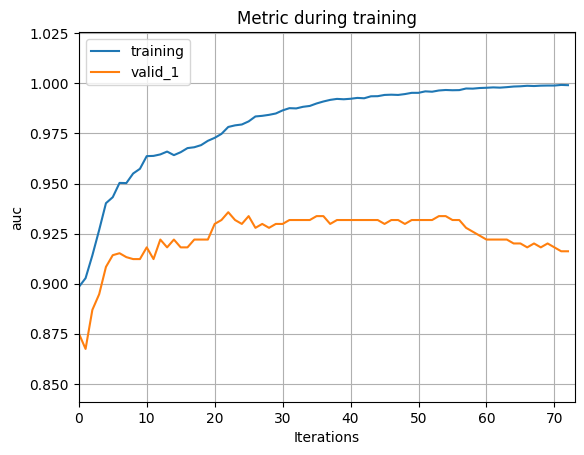

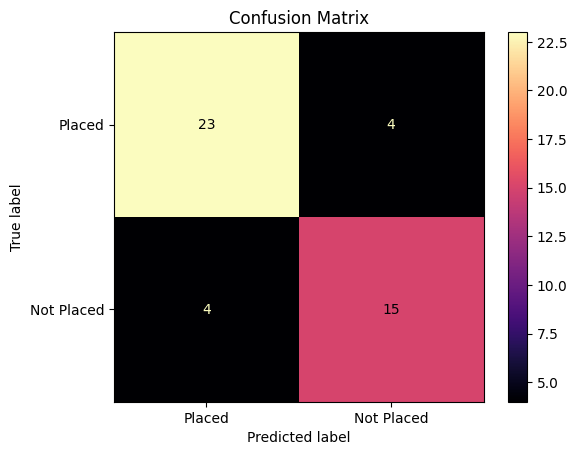

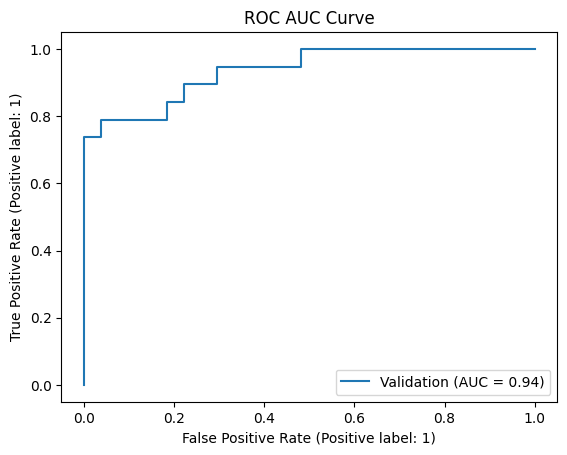

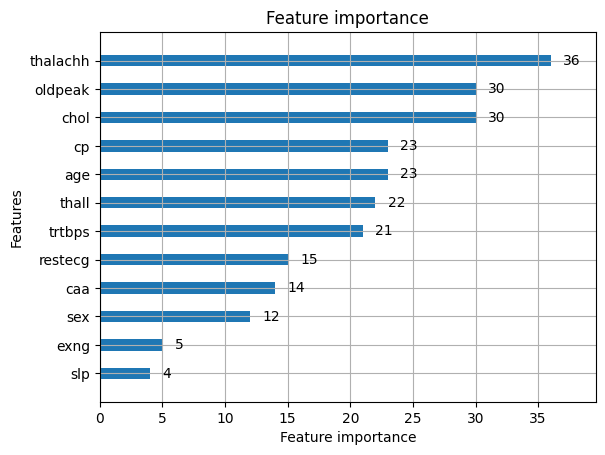

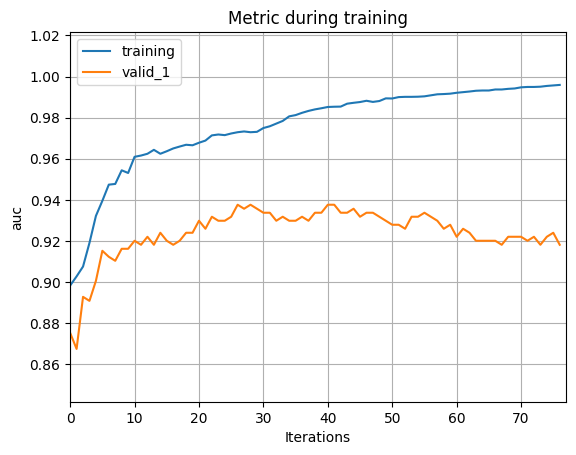

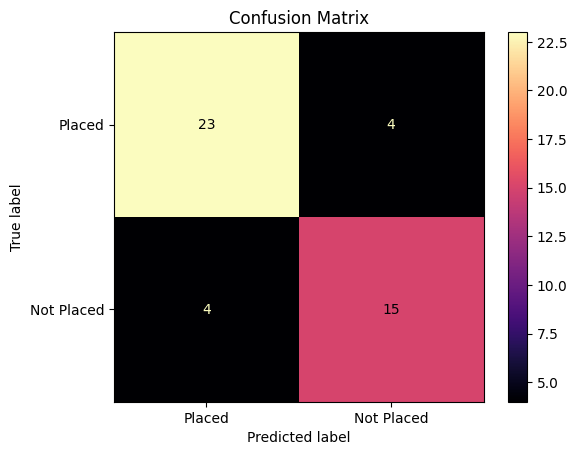

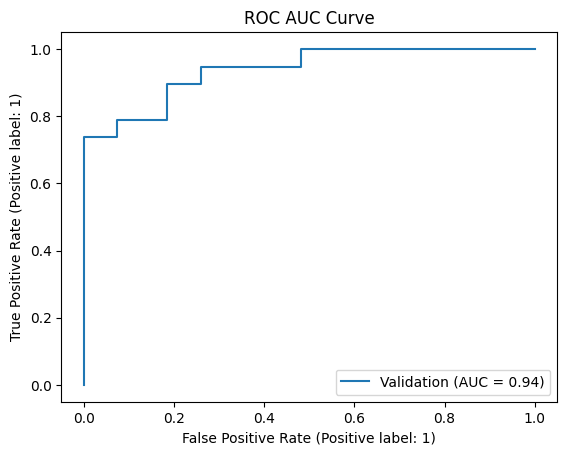

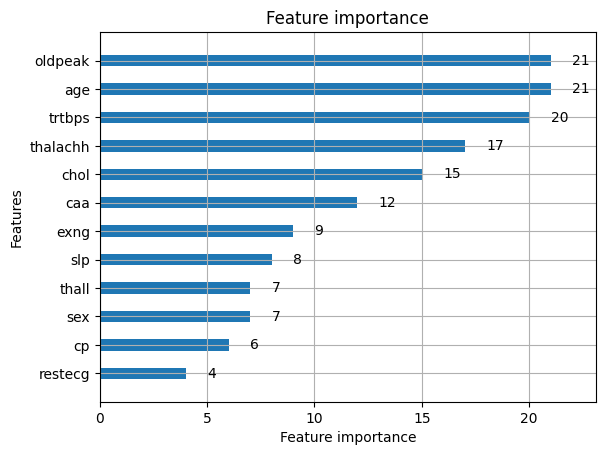

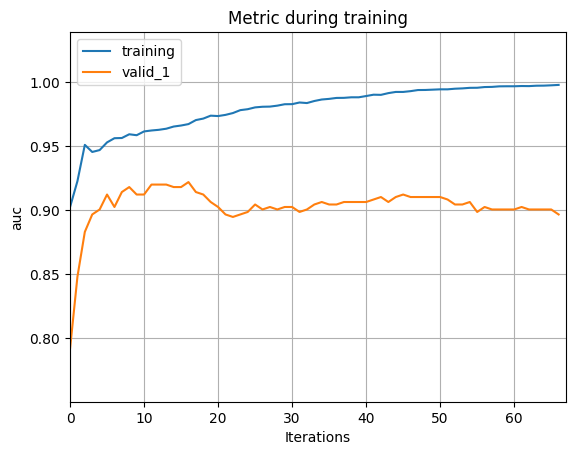

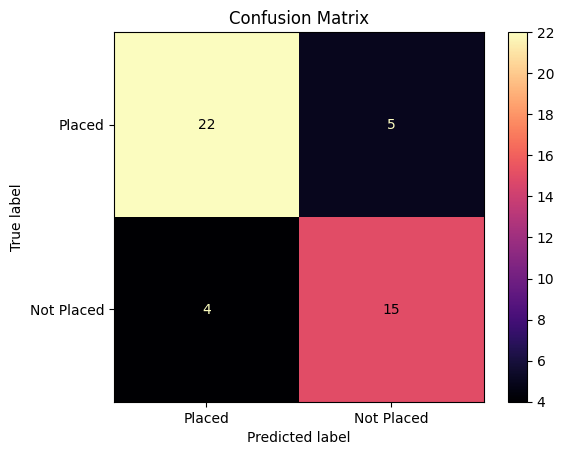

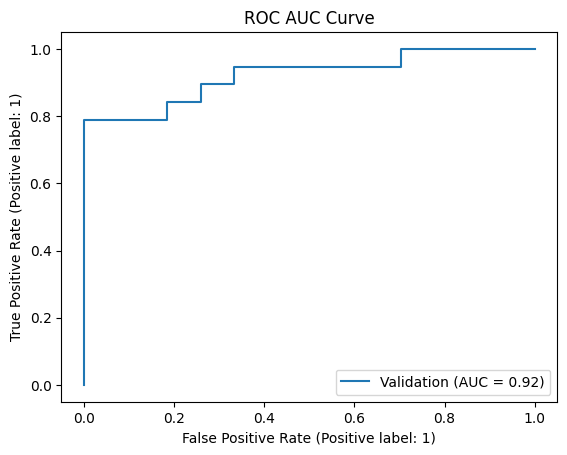

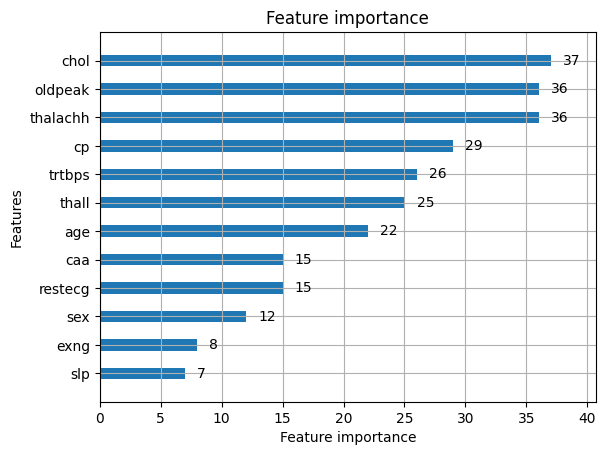

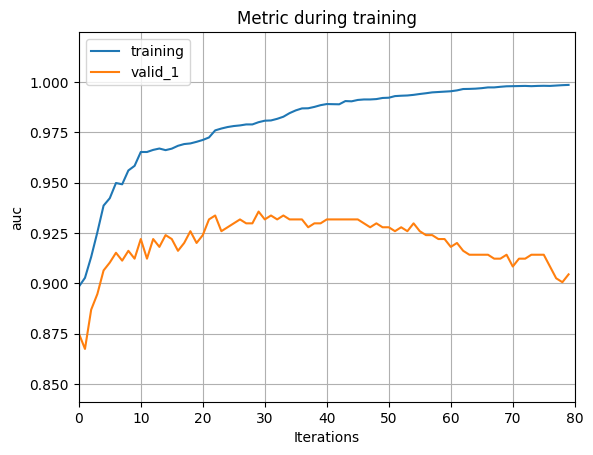

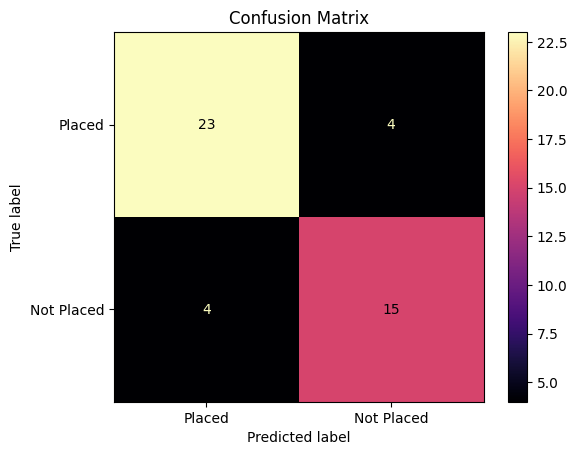

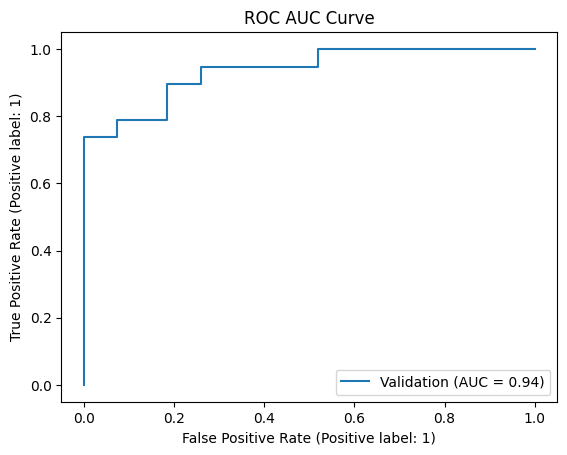

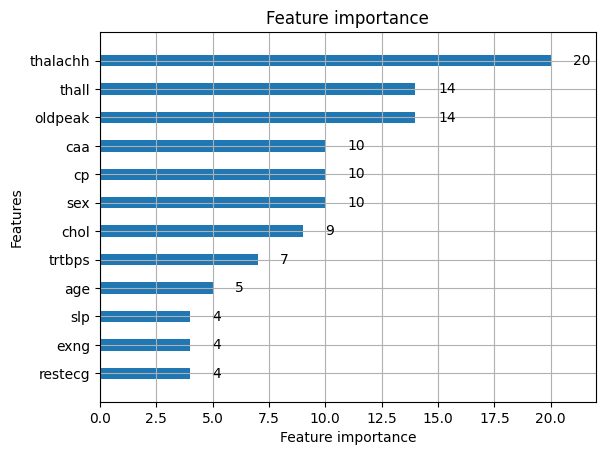

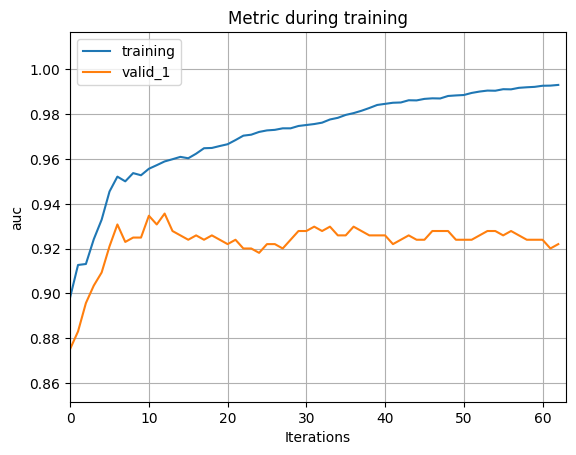

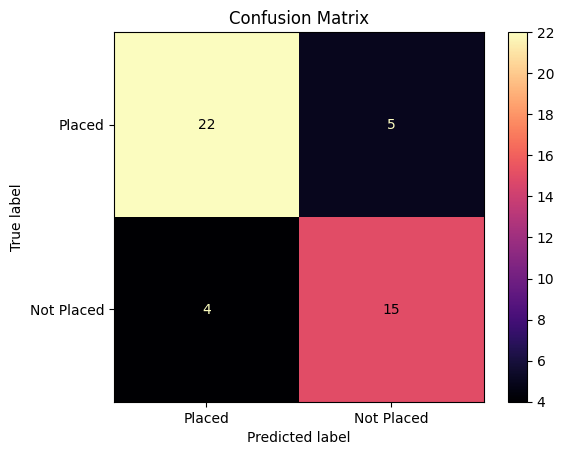

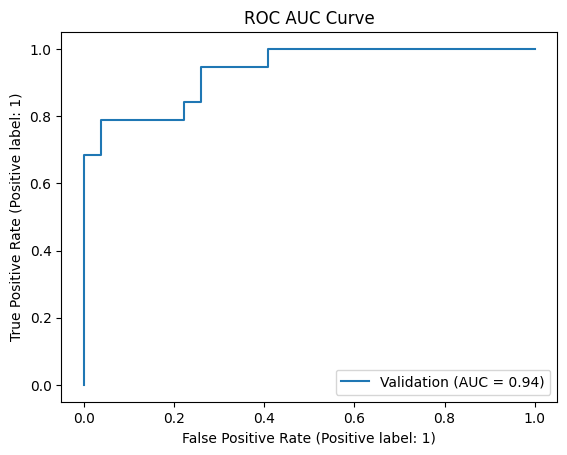

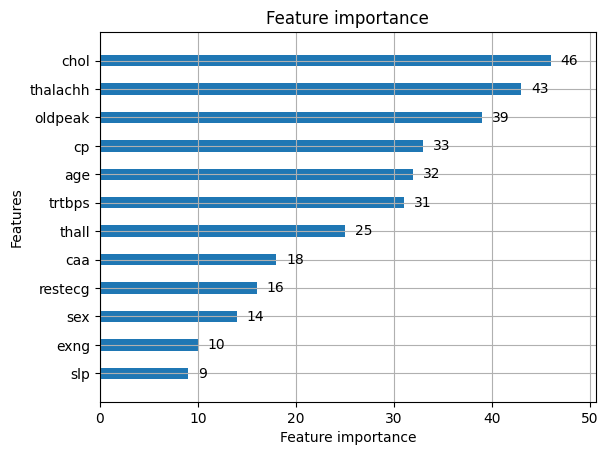

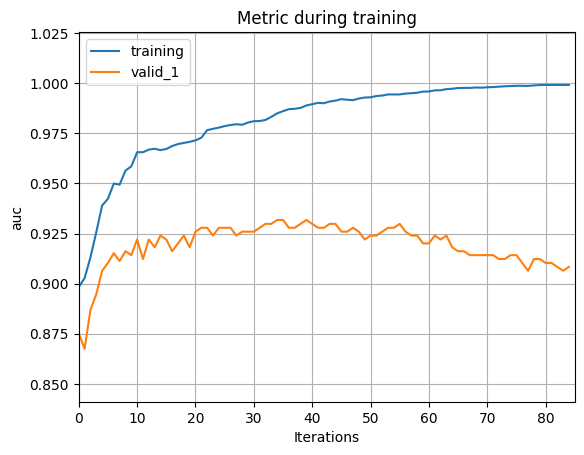

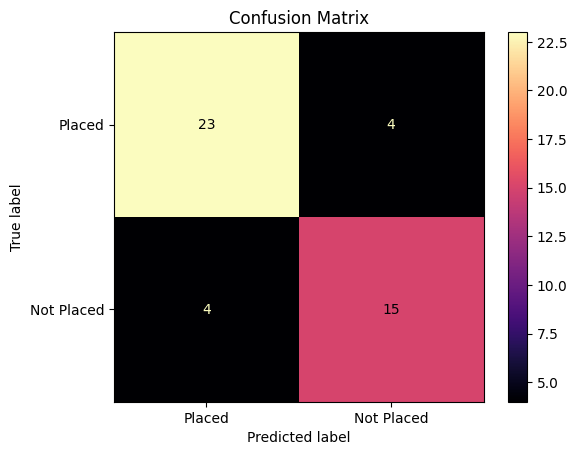

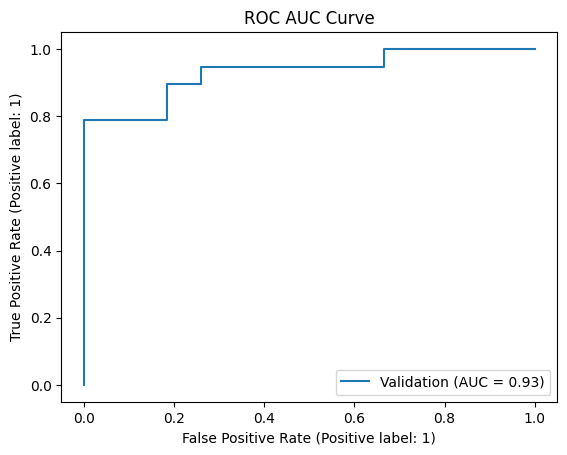

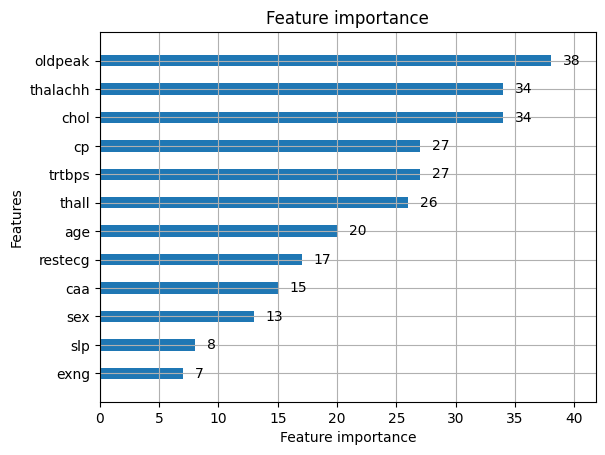

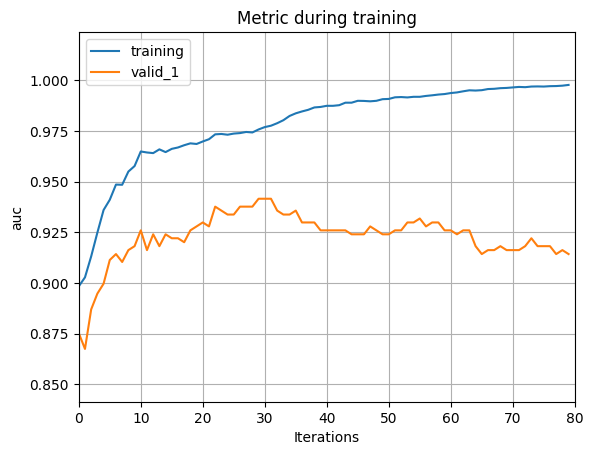

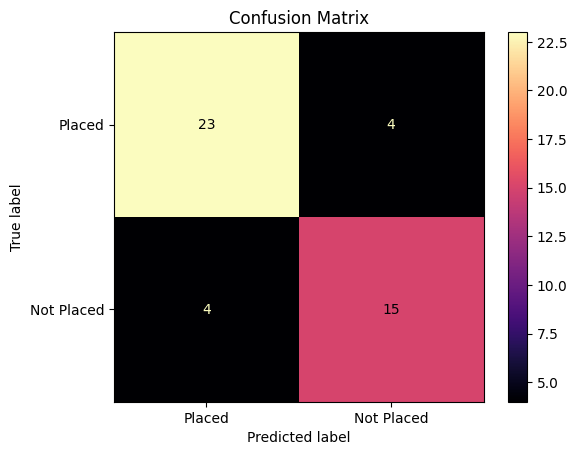

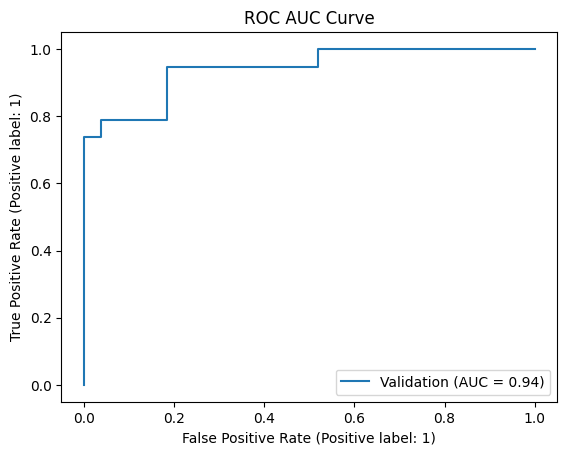

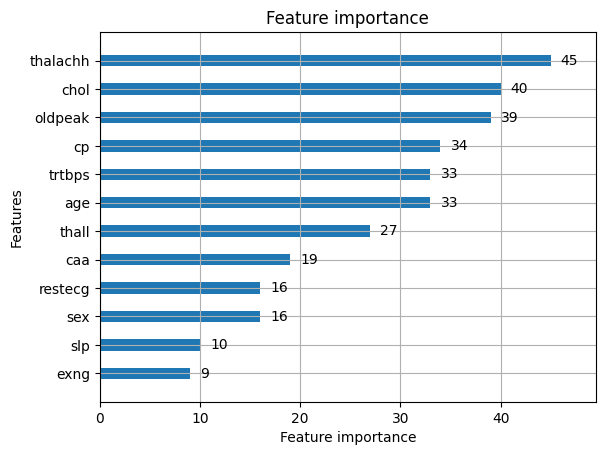

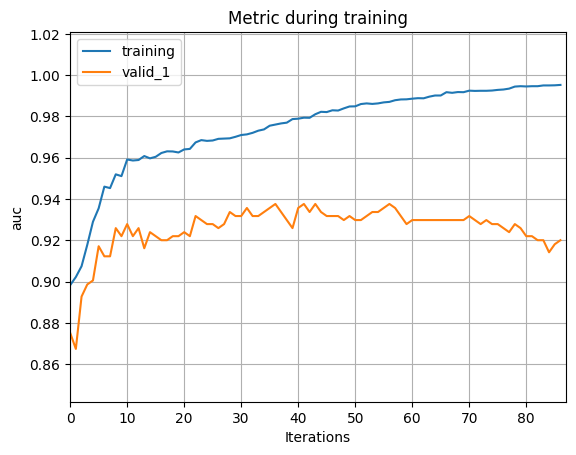

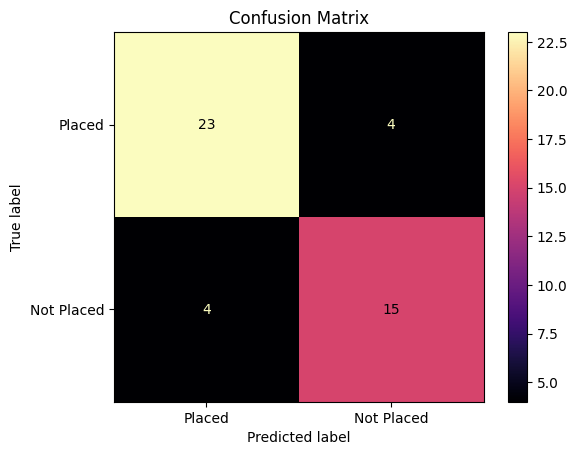

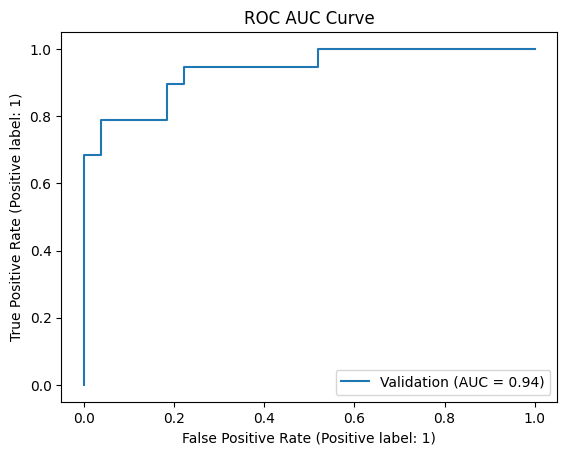

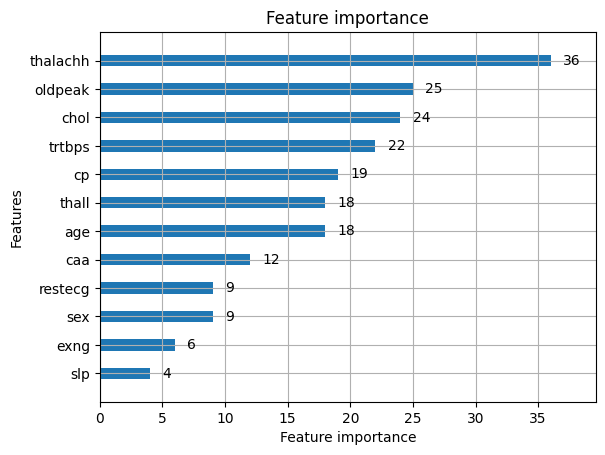

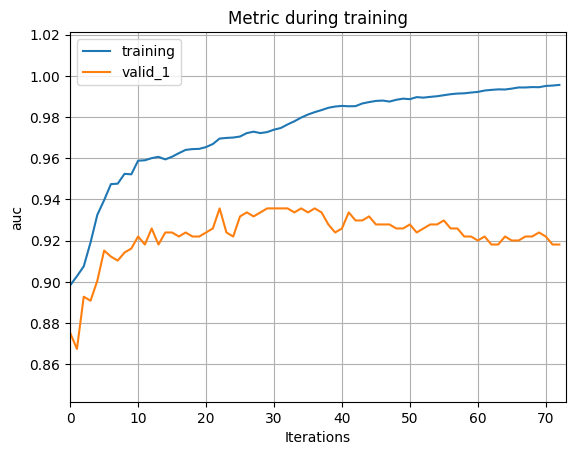

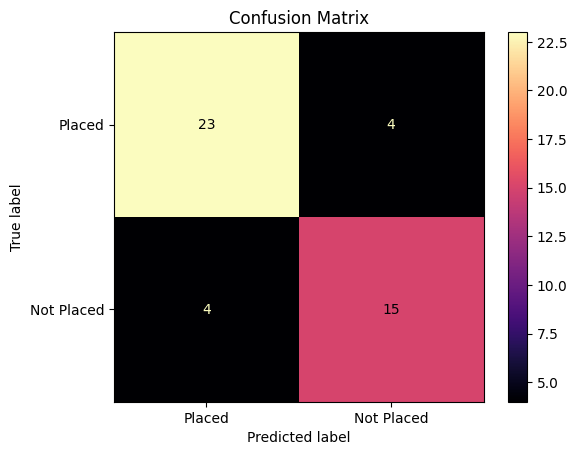

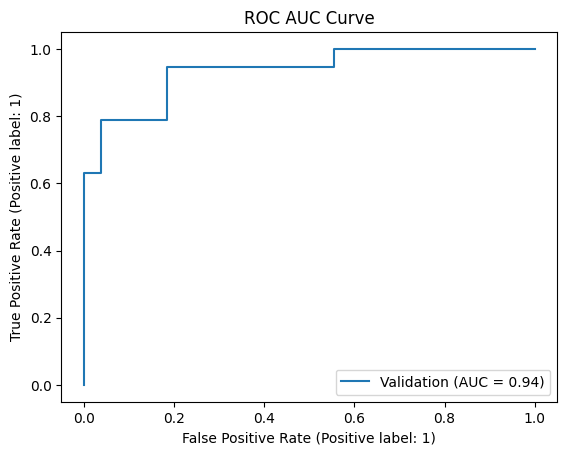

In [38]:
# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)
trial = study.best_trial
print('AUC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

## Load best lightgbm model

Check Mlflow UI and pick the best model for model deployment

In [39]:
import mlflow 
client = mlflow.tracking.MlflowClient()
runs = client.search_runs(experiment_id, "", order_by=["metrics.auc DESC"], max_results=1)

#Fetching Run ID for
run_id = runs[0]._info.run_id

#best_run_id = runs[0].params #['mlflow.domino.run_id']
lgb_best_model = mlflow.pyfunc.load_model("runs:/" + run_id + "/model")

2023/10/17 21:59:36 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [40]:

# Make prediction aganist Validation data
lgb_best_val_prediction = lgb_best_model.predict(X_valid)
lgb_best_val_prediction

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0])

In [41]:
import mlflow
import pickle
import datetime


# define a custom model
class heart_attack_model(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        with open(context.artifacts["heart_attack_model"], "rb") as f:
            self.model = pickle.load(f)
            # from domino_prediction_logging.prediction_client import PredictionClient
            from domino_data_capture.data_capture_client import DataCaptureClient

            features = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
                   'exng', 'oldpeak', 'slp', 'caa', 'thall']

            target = ["target"]

            # pred_client = PredictionClient(features, target)
            self.data_capture_client = DataCaptureClient(features, target)

#    def predict(age, sex, cp, trtbps, chol, fbs, restecg, thalachh,
#           exng, oldpeak, slp, caa, thall, _id=None):
    def predict(self, context, model_input):

        '''
        data = [ {
            "age" : age, 
            "sex" : sex,
            "cp" : cp, 
            "trtbps" : trtbps, 
            "chol" : chol, 
            "fbs" : fbs, 
            "restecg" : restecg, 
            "thalachh" : thalachh,
            "exng" : exng, 
            "oldpeak" : oldpeak, 
            "slp" : slp, 
            "caa" :caa, 
            "thall" :thall
        }]
        '''
        print(type(model_input))
        print(model_input)
        #print('age', model_input[0].age)
        #data = [model_input]
        #df = pd.DataFrame(data)
        #print(df)

        predictions = self.model.predict(model_input).tolist()

        print('prediction        : ', type(predictions))
        print('prediction Values : ', predictions)

        # Record eventID and current time
        _id = str(datetime.datetime.now())
        # custid = uuid.uuid4()
        print('ID is: {}'.format(_id))

        feature_values=[model_input.age, model_input.sex, model_input.cp, model_input.trtbps, model_input.chol, 
                        model_input.fbs, model_input.restecg, model_input.thalachh,
           model_input.exng, model_input.oldpeak, model_input.slp, model_input.caa, model_input.thall]
        feature_values = model_input.values.tolist()
        print('feature_values', feature_values)
        # pred_client.record(feature_values, prediction, event_id=custid)
        for i in range(len(feature_values)) :
            print('feature_values[i] : ', feature_values[i])
            print('predictions[i] : ', predictions[i])
            self.data_capture_client.capturePrediction(feature_values[i], [predictions[i]],event_id=_id)

        return dict(prediction=predictions)




In [42]:
import os 
import pickle
#mlflow.end_run()
from mlflow.models.signature import infer_signature
model_tmp = './'
registered_model = "lgb_heart_attack_model"
heart_attack_model_dir_path = os.path.join(model_tmp, "model/model.pkl")
run = mlflow.get_run(run_id)
with mlflow.start_run(run_id=run_id) :

    with open(heart_attack_model_dir_path, "wb") as f:
        pickle.dump(lgb_best_model, f)


    # Create a dictionary to tell MLflow where the necessary artifacts are
    artifacts = {
                "heart_attack_model": heart_attack_model_dir_path,
            }
    model_signature = infer_signature(X_train, 
                  lgb_best_model.predict(X_train))

    mlflow.pyfunc.log_model(
                    artifact_path='heart_attack_model_path',
                    python_model=heart_attack_model(),
                    code_path=["./model_src"],
                    artifacts=artifacts,
                    registered_model_name=registered_model,
                    signature=model_signature
                )



Registered model 'lgb_heart_attack_model' already exists. Creating a new version of this model...
2023/10/17 21:59:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: lgb_heart_attack_model, version 7
Created version '7' of model 'lgb_heart_attack_model'.


## Reference

### Model experimentation
https://www.mlflow.org/docs/latest/tracking.html#

### Hyperparameter Optimization
https://github.com/optuna/optuna

In [3]:
#!pip install dominodatalab

In [43]:
import os


    
from domino import Domino

domino = Domino(
    "pok8/Heart-Attack-prediction",
    api_key="e96911141303c50867a8f331b4abdf0ca9f7719e7111b605d87fcec7d6b5ca29",
    host="https://cdc-sandbox.domino-eval.com"
)

#if domino.endpoint_publish(
#    "./model_src/heart_attack_model.py", "predict", "aa60aab64e8e47e49f63948651671eb9"
#):
#    print("API endpoint published!")
#else:
#    print("API endpoint could not be published")

In [49]:
from domino import Domino

# By and large your commands will run against a single project,
# so you must specify the full project name
#domino = Domino("chris/canon")

# List all runs in the project, most-recently queued first
all_runs = domino.runs_list()['data']

latest_100_runs = all_runs[0:100]

#print(latest_100_runs)

# all runs have a commitId (the snapshot of the project when the
# run starts) and, if the run completed, an "outputCommitId"
# (the snapshot of the project after the run completed)
most_recent_run = all_runs[0]

commitId = most_recent_run['commitId']
print('commitId', commitId)
# list all the files in the output commit ID -- only showing the
# entries under the results directory.  If not provided, will
# list all files in the project.  Or you can say path=“/“ to
# list all files
files = domino.files_list(commitId, path='results/')['data']

#for file in files:
#print file['path'], '->', file['url']

print(files)

# Get the content (i.e. blob) for the file you're interested in.
# blobs_get returns a connection rather than the content, because
# the content can get quite large and it's up to you how you want
# to handle it
#print(domino.blobs_get(files[0]['key']).read())

# Start a run of file main.py using the latest copy of that file
domino.runs_start(["main.py", "arg1", "arg2"])

# Start a "direct" command
#domino.runs_start(["echo 'Hello, World!'"], isDirect=True)

# Start a run of a specific commit
#domino.runs_start(["main.py"], commitId="aabbccddee")

commitId ae5eb1bc5d5df130b9e70c1cce9d3930a9eb262d
[{'path': 'results/stdout.txt', 'lastModified': 1697496757000, 'size': 40115, 'key': 'd9c1d422ad4df7e7c510a0af3ecf875feaebcc4f', 'url': 'https://cdc-sandbox.domino-eval.com/v1/blobs/d9c1d422ad4df7e7c510a0af3ecf875feaebcc4f'}]
b'[I 18:44:23.682 NotebookApp] Writing notebook server cookie secret to /home/ubuntu/.local/share/jupyter/runtime/notebook_cookie_secret\n[I 18:44:23.683 NotebookApp] Authentication of /metrics is OFF, since other authentication is disabled.\n[W 18:44:23.883 NotebookApp] All authentication is disabled.  Anyone who can connect to this server will be able to run code.\n[W 18:44:25.511 NotebookApp] Loading JupyterLab as a classic notebook (v6) extension.\n[C 18:44:25.511 NotebookApp] You must use Jupyter Server v1 to load JupyterLab as notebook extension. You have v2.7.0 installed.\n    You can fix this by executing:\n        pip install -U "jupyter-server<2.0.0"\n[C 18:44:25.592 NotebookApp] You must use Jupyter Serv

In [45]:
latest_100_runs = all_runs[0]

In [46]:
latest_100_runs

{'id': '652ef64df66ed97e65980e60',
 'projectId': '650ddf9e5ab24c14cb26acaf',
 'number': 36,
 'startingUserId': '650465090a7f750eb5f7335a',
 'queued': 1697576525485,
 'started': 1697576540924,
 'completed': None,
 'status': 'Running',
 'commitId': 'ae5eb1bc5d5df130b9e70c1cce9d3930a9eb262d',
 'startingScheduledRunId': None,
 'outputCommitId': None,
 'title': 'heart-attack-binary-classifer',
 'publiclyVisible': False,
 'isArchived': False,
 'postProcessedTimestamp': None,
 'diagnosticStatistics': None,
 'isCompleted': False,
 'hardwareTierId': 'small-k8s',
 'environmentId': '650255d38f2b224c6b1e2ab9',
 'environmentRevisionId': '6515e61a0a7f750eb5f7377e',
 'repositories': [{'id': '650ddf9e5ab24c14cb26acb1',
   'name': 'heart-attack',
   'ref': '(Default branch)',
   'serviceProvider': 'github',
   'startingCommitId': '-',
   'finishedCommitId': '-',
   'uri': 'https://github.com/vijtad/heart-attack.git',
   'startingBranch': '-',
   'finishedBranch': '-'}],
 'notebookName': 'Jupyter (Pytho